# Tech Challenge - Fase 3: Machine Learning Engineering
## Análise e Previsão de Atrasos de Voos

**Objetivo:** Este projeto visa analisar dados históricos de voos para identificar padrões de atrasos e construir um modelo preditivo capaz de estimar a probabilidade de atraso de um voo.

**Metodologia:**
1. Coleta e limpeza dos dados brutos (voos, companhias aéreas e aeroportos).
2. Tratamento de valores nulos baseado em regras de negócio (ex: voos cancelados).
3. Análise Exploratória (EDA) para insights visuais.
4. Engenharia de Atributos e Modelagem Preditiva.

In [1]:
# -------------------------------------------------------------------
# TECH CHALLENGE - FASE 3: MACHINE LEARNING ENGINEERING
# Esqueleto de Código para Análise de Atrasos de Voos
# -------------------------------------------------------------------

# --- Importar Bibliotecas --- #

# --- Bibliotecas de Manipulação de Dados ---
import pandas as pd
import numpy as np
from collections import OrderedDict

# --- Bibliotecas de Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

# --- Bibliotecas de Machine Learning ---
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from category_encoders import CountEncoder
from scipy.stats import randint, uniform

# --- Configurações do Pandas para mostrar todas as colunas em dataframes ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

# --- Configurações de Avisos ---
import warnings
warnings.filterwarnings('ignore')

In [2]:
def verify_null_counts(data):

  """
  Verify null counts and null percent
  """

  total_rows = len(data)
  null_counts = data.isnull().sum()

  null_percentage = (null_counts / total_rows) * 100
  null_data = null_counts[null_counts > 0]

  if null_data.empty:
      print("Nenhum valor nulo encontrado.")
  else:
      for col in null_data.index:
          print(f'{col}: {null_data[col]} ({null_percentage[col]:.2f}%)')

In [3]:
def print_statics_values(data_dict):
  '''
  Input : Data dictonary
  Output : Data shape, Data describe , Data info for each dataframe inside in the dict
  '''
  for name, key in data_dict.items():
        print("=" * 60)
        print(f"=== DataFrame: {name} ===")

        print(f"Shape: {key.shape}")

        print("\nDescribe:")
        print(key.describe())

        print("\nInfo:")
        key.info()

        print("=" * 60, "\n")


## Exploração dos dados (EDA)

In [4]:
# Carregando os 3 arquivos de dados
try:
    # Adicionando 'on_bad_lines="skip"' para ignorar linhas malformadas
    df_flights = pd.read_csv('flights.csv', on_bad_lines='skip')
    df_airlines = pd.read_csv('airlines.csv')
    df_airports = pd.read_csv('airports.csv')
    print("Arquivos carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivo: {e}")
    print("Certifique-se de que os 3 arquivos CSV estão no mesmo diretório do seu notebook.")
    # Se der erro, não podemos continuar
    raise e

Arquivos carregados com sucesso.


In [5]:
dataframes = {
    'Flights':df_flights,
    'Airlines':df_airlines,
    'Airports':df_airports
}

In [6]:
print_statics_values(dataframes)

=== DataFrame: Flights ===
Shape: (5819079, 31)

Describe:
            YEAR      MONTH        DAY  DAY_OF_WEEK  FLIGHT_NUMBER  \
count 5819079.00 5819079.00 5819079.00   5819079.00     5819079.00   
mean     2015.00       6.52      15.70         3.93        2173.09   
std         0.00       3.41       8.78         1.99        1757.06   
min      2015.00       1.00       1.00         1.00           1.00   
25%      2015.00       4.00       8.00         2.00         730.00   
50%      2015.00       7.00      16.00         4.00        1690.00   
75%      2015.00       9.00      23.00         6.00        3230.00   
max      2015.00      12.00      31.00         7.00        9855.00   

       SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY   TAXI_OUT  \
count           5819079.00      5732926.00       5732926.00 5730032.00   
mean               1329.60         1335.20             9.37      16.07   
std                 483.75          496.42            37.08       8.90   
min           

In [7]:
df_airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [8]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65,-75.44
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41,-99.68
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04,-106.61
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.45,-98.42
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.54,-84.19


In [9]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.00,-11.00,21.00,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.00,-8.00,12.00,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.00,-2.00,16.00,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.00,-5.00,15.00,30.00,285.00,281.00,258.00,2342,748.00,8.00,805,756.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.00,-1.00,11.00,35.00,235.00,215.00,199.00,1448,254.00,5.00,320,259.00,-21.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN


##  Verificar valores ausentes antes do tratamento


In [10]:
verify_null_counts(df_airlines)

Nenhum valor nulo encontrado.


In [11]:
verify_null_counts(df_airports)

LATITUDE: 3 (0.93%)
LONGITUDE: 3 (0.93%)


In [12]:
verify_null_counts(df_flights)

TAIL_NUMBER: 14721 (0.25%)
DEPARTURE_TIME: 86153 (1.48%)
DEPARTURE_DELAY: 86153 (1.48%)
TAXI_OUT: 89047 (1.53%)
WHEELS_OFF: 89047 (1.53%)
SCHEDULED_TIME: 6 (0.00%)
ELAPSED_TIME: 105071 (1.81%)
AIR_TIME: 105071 (1.81%)
WHEELS_ON: 92513 (1.59%)
TAXI_IN: 92513 (1.59%)
ARRIVAL_TIME: 92513 (1.59%)
ARRIVAL_DELAY: 105071 (1.81%)
CANCELLATION_REASON: 5729195 (98.46%)
AIR_SYSTEM_DELAY: 4755640 (81.72%)
SECURITY_DELAY: 4755640 (81.72%)
AIRLINE_DELAY: 4755640 (81.72%)
LATE_AIRCRAFT_DELAY: 4755640 (81.72%)
WEATHER_DELAY: 4755640 (81.72%)


In [13]:
# Renomear coluna para evitar conflito no merge
df_airlines.rename(columns={'AIRLINE': 'AIRLINE_NAME'}, inplace=True)

In [14]:
# Juntar flights com airlines para ter os nomes das companhias
df_flights_completo = pd.merge(df_flights, df_airlines, left_on ='AIRLINE', right_on ='IATA_CODE', how='left')
print(f"Merge de 'flights' e 'airlines' concluído. Total de linhas: {len(df_flights_completo)}")
print(df_flights_completo[['YEAR', 'AIRLINE', 'IATA_CODE', 'AIRLINE_NAME', 'ARRIVAL_DELAY']].head())

Merge de 'flights' e 'airlines' concluído. Total de linhas: 5819079
   YEAR AIRLINE IATA_CODE            AIRLINE_NAME  ARRIVAL_DELAY
0  2015      AS        AS    Alaska Airlines Inc.         -22.00
1  2015      AA        AA  American Airlines Inc.          -9.00
2  2015      US        US         US Airways Inc.           5.00
3  2015      AA        AA  American Airlines Inc.          -9.00
4  2015      AS        AS    Alaska Airlines Inc.         -21.00


In [15]:
df_flights_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

# DEFINIÇÃO DAS LISTAS E COLUNAS PARA LIMPEZA E PRÉ-PROCESSAMENTO (DATA CLEANING)

Objetivo será tratar os dados a partir da informação se um voo foi cancelado ou não para definir as demais limpezas

In [16]:
#Variavel com colunas de voos com delay para consultarmos
delay_columns = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY',
                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
                 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'DEPARTURE_TIME'
]

# Consultar se há dados incorretamente gravados, pois se um voo foi cancelado (CANCELLED == 1), ele não deveria ter dados de voo da coluna delay. Após essa verificação, preencheremos esses valores com 0.
cancelled_flights = df_flights_completo['CANCELLED'] == 1
df_flights_completo.loc[cancelled_flights, delay_columns] = df_flights_completo.loc[cancelled_flights, delay_columns].fillna(0)

In [17]:
# Nota-se que todas colunas CANCELLED e CANCELLATION_REASON possuem relação, pois quando CANCELLED == 1, CANCELLATION_REASON sempre possui um valor (A, B, C ou D). 
# Quando CANCELLED == 0, CANCELLATION_REASON é NaN. Portanto, ambas colunas podem ser mantidas para análises futuras.
df_flights_completo['CANCELLED'].value_counts()

CANCELLED
0    5729195
1      89884
Name: count, dtype: int64

In [18]:
df_flights_completo['CANCELLATION_REASON'].value_counts()

CANCELLATION_REASON
B    48851
A    25262
C    15749
D       22
Name: count, dtype: int64

In [19]:
razoes_cancelamento = {
    'A': 'Airline',
    'B': 'Weather',
    'C': 'NAS',      # Sigla para "National Airspace System"
    'D': 'Security'
}

df_flights_completo['CANCELLATION_REASON'] = df_flights_completo['CANCELLATION_REASON'].replace(razoes_cancelamento)

df_flights_completo['CANCELLATION_REASON'].value_counts()

CANCELLATION_REASON
Weather     48851
Airline     25262
NAS         15749
Security       22
Name: count, dtype: int64

In [20]:
# Colunas onde NaN significa '0' em voos NÃO CANCELADOS. Se o voo não foi cancelado e as colunas de delay estão vazias, considera-se que o atraso foi zero.
colunas_componentes_delay = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLATION_REASON'
]

nao_cancelado =df_flights_completo['CANCELLED'] == 0
df_flights_completo.loc[nao_cancelado, colunas_componentes_delay] = df_flights_completo.loc[nao_cancelado, colunas_componentes_delay].fillna(0)

In [21]:
# Dropar linhas onde informações essenciais estão faltando e não faz sentido haver valores nulos
df_flights_completo.dropna(subset=['AIRLINE_NAME', 'TAIL_NUMBER', 'SCHEDULED_TIME','ARRIVAL_DELAY', 'DISTANCE'], inplace=True)

In [22]:
# Organizar as informações de data
df_flights_completo['FLIGHT_DATE'] = pd.to_datetime(df_flights_completo[['YEAR', 'MONTH', 'DAY']])
df_flights_completo.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True)

In [23]:
# Converter colunas de tempo/atraso para Inteiro
int_columns = [
    'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
    'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

df_flights_completo[int_columns] = df_flights_completo[int_columns].fillna(0).astype('int64')
print("\n--- LIMPEZA DE DADOS CONCLUÍDA ---")
print(f"Total de linhas finais no arquivo df_flights: {len(df_flights_completo)}")
verify_null_counts(df_flights_completo)


--- LIMPEZA DE DADOS CONCLUÍDA ---
Total de linhas finais no arquivo df_flights: 5789166
Nenhum valor nulo encontrado.


In [24]:
df_flights_completo.head()

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_NAME,FLIGHT_DATE
0,4,AS,98,N407AS,ANC,SEA,5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01
1,4,AA,2336,N3KUAA,LAX,PBI,10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01
2,4,US,840,N171US,SFO,CLT,20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,0,0,0,0,0,0,US,US Airways Inc.,2015-01-01
3,4,AA,258,N3HYAA,LAX,MIA,20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01
4,4,AS,135,N527AS,SEA,ANC,25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01


## Tratando Arquivo CSV df_airports


In [25]:
df_airports.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [26]:
df_airports.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
verify_null_counts(df_airports)

Nenhum valor nulo encontrado.


In [27]:
df_airports.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  319 non-null    object 
 1   AIRPORT    319 non-null    object 
 2   CITY       319 non-null    object 
 3   STATE      319 non-null    object 
 4   COUNTRY    319 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 19.9+ KB


In [28]:
# Organizando as colunas e unindo dados de localização dos aeroportos de origem e destino
df_flights_completo = pd.merge(
    df_flights_completo,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'STATE']],
    left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_ORIGIN')
)
df_flights_completo.rename(columns={
    'LATITUDE': 'ORIGIN_LATITUDE', 'LONGITUDE': 'ORIGIN_LONGITUDE',
    'CITY': 'ORIGIN_CITY', 'STATE': 'ORIGIN_STATE'
}, inplace=True)
df_flights_completo.drop(columns=['IATA_CODE_ORIGIN'], inplace=True)

df_flights_completo = pd.merge(
    df_flights_completo,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'STATE']],
    left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_DEST')
)
df_flights_completo.rename(columns={
    'LATITUDE': 'DESTINATION_LATITUDE', 'LONGITUDE': 'DESTINATION_LONGITUDE',
    'CITY': 'DESTINATION_CITY', 'STATE': 'DESTINATION_STATE'
}, inplace=True)
df_flights_completo.drop(columns=['IATA_CODE_DEST'], inplace=True)

airport_geo_cols = [
    'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_CITY', 'ORIGIN_STATE',
    'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'DESTINATION_CITY', 'DESTINATION_STATE'
]
df_flights_completo.dropna(subset=airport_geo_cols, inplace=True)


In [29]:
verify_null_counts(df_flights_completo)

Nenhum valor nulo encontrado.


In [30]:
df_flights_completo.drop_duplicates(inplace=True)

In [31]:
df_flights_completo.head()

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_NAME,FLIGHT_DATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE
0,4,AS,98,N407AS,ANC,SEA,5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01,61.17,-150.00,Anchorage,AK,47.45,-122.31,Seattle,WA
1,4,AA,2336,N3KUAA,LAX,PBI,10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01,33.94,-118.41,Los Angeles,CA,26.68,-80.10,West Palm Beach,FL
2,4,US,840,N171US,SFO,CLT,20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,0,0,0,0,0,0,US,US Airways Inc.,2015-01-01,37.62,-122.37,San Francisco,CA,35.21,-80.94,Charlotte,NC
3,4,AA,258,N3HYAA,LAX,MIA,20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01,33.94,-118.41,Los Angeles,CA,25.79,-80.29,Miami,FL
4,4,AS,135,N527AS,SEA,ANC,25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,0,0,0,0,0,0,AS,Alaska Airlines Inc.,2015-01-01,47.45,-122.31,Seattle,WA,61.17,-150.00,Anchorage,AK


# Análise Exploratória (EDA)


Gerando Heatmap de Correlação...


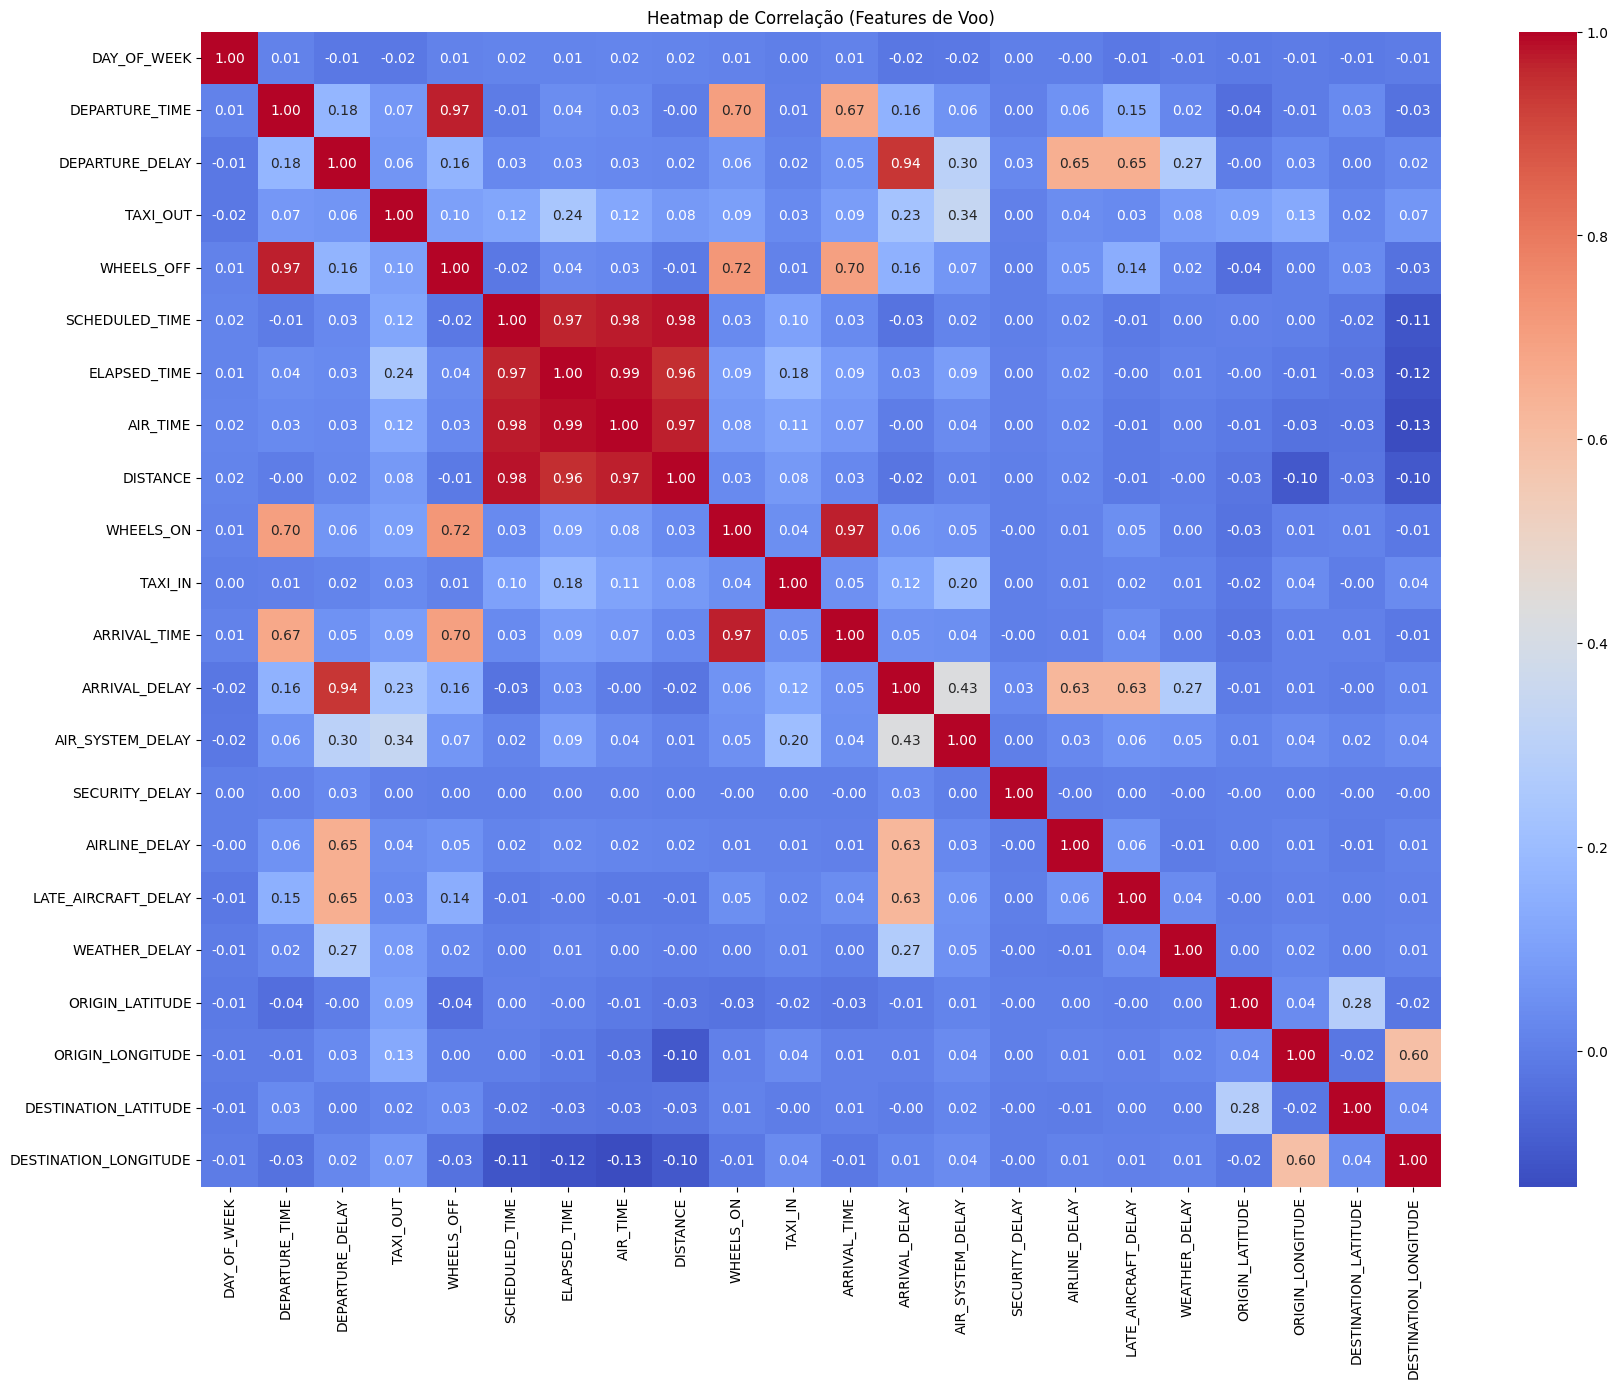

In [32]:
def correlation_mapping(data):
  """
  Gera um heatmap de correlação.
  """
  print("\nGerando Heatmap de Correlação...")
  df_flights_limpo = data.copy()

  # Remover colunas que não representam variáveis numéricas contínuas
  numeric_cols = df_flights_limpo.select_dtypes(include='number').columns.tolist()
  cols_to_remove = ['FLIGHT_NUMBER', 'DIVERTED', 'CANCELLED', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']
  plot_cols = [col for col in numeric_cols if col not in cols_to_remove]
  var_numerical = df_flights_limpo[plot_cols]

  plt.figure(figsize=(20, 15))
  corr = var_numerical.corr()
  sns.heatmap(corr,
              annot=True,
              fmt='.2f',
              cmap='coolwarm'
              )
  plt.title('Heatmap de Correlação (Features de Voo)')


correlation_mapping(df_flights_completo)

## Variáveis com Forte Correlação
Várias variáveis exibem correlações extremamente altas, indicando redundância. Elas descrevem aspectos muito similares do voo.


DEPARTURE_DELAY ↔ ARRIVAL_DELAY (0.94)

SCHEDULED_TIME ↔ ELAPSED_TIME ↔ AIR_TIME ↔ DISTANCE (0.96 a 0.99)

DEPARTURE_TIME ↔ WHEELS_OFF (0.97)

ARRIVAL_TIME ↔ WHEELS_ON (0.97)

LATE_AIRCRAFT_DELAY ↔ DEPARTURE_DELAY (0.65)


## Variáveis com Correlação Fraca ou Nula
Estas variáveis mostram pouca ou nenhuma relação linear direta com as demais, especialmente com as variáveis de atraso (target). Elas podem não contribuir significativamente para modelos lineares simples sem transformação prévia:

DAY_OF_WEEK ↔ Qualquer outra variável (correlações próximas a 0.00)

ORIGIN_LATITUDE / LONGITUDE ↔ DEPARTURE_DELAY (correlações nulas ou negativas muito baixas)

TAXI_IN ↔ DISTANCE (0.08)

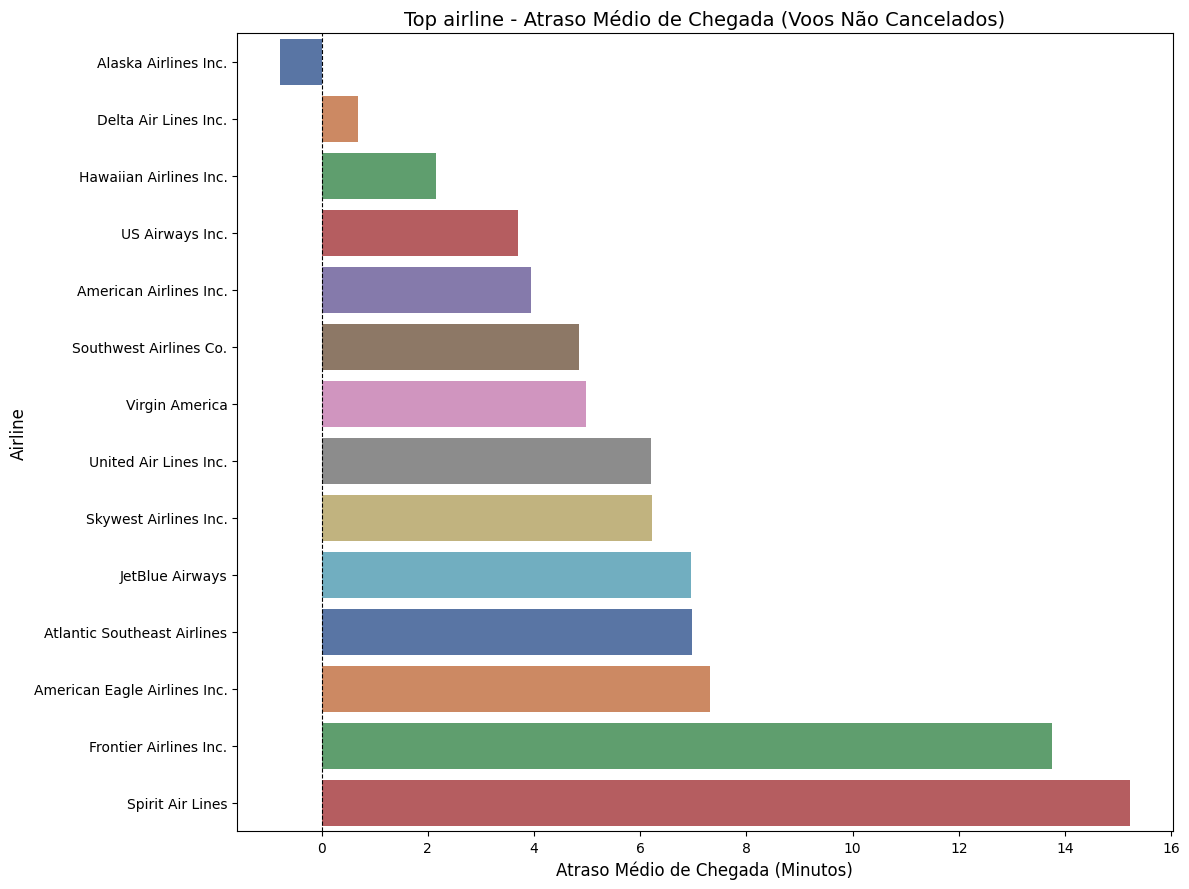

In [33]:
def plot_delay_by_airline(data):
  """
    Plota a Média delay por companhia

  """
  df_non_cancelled = data[data['CANCELLED'] == 0].copy()
  airline_delay = df_non_cancelled.groupby('AIRLINE_NAME')['ARRIVAL_DELAY'].mean().sort_values()

  plt.figure(figsize=(12, 9))
  sns.barplot(x=airline_delay.values, y=airline_delay.index, orient='h', palette='deep', hue=airline_delay.index, legend=False)
  plt.title('Top airline - Atraso Médio de Chegada (Voos Não Cancelados)', fontsize=14)
  plt.xlabel('Atraso Médio de Chegada (Minutos)', fontsize=12)
  plt.ylabel('Airline', fontsize=12)
  plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # Linha vertical no 0
  plt.tight_layout()
  plt.show()

plot_delay_by_airline(df_flights_completo)

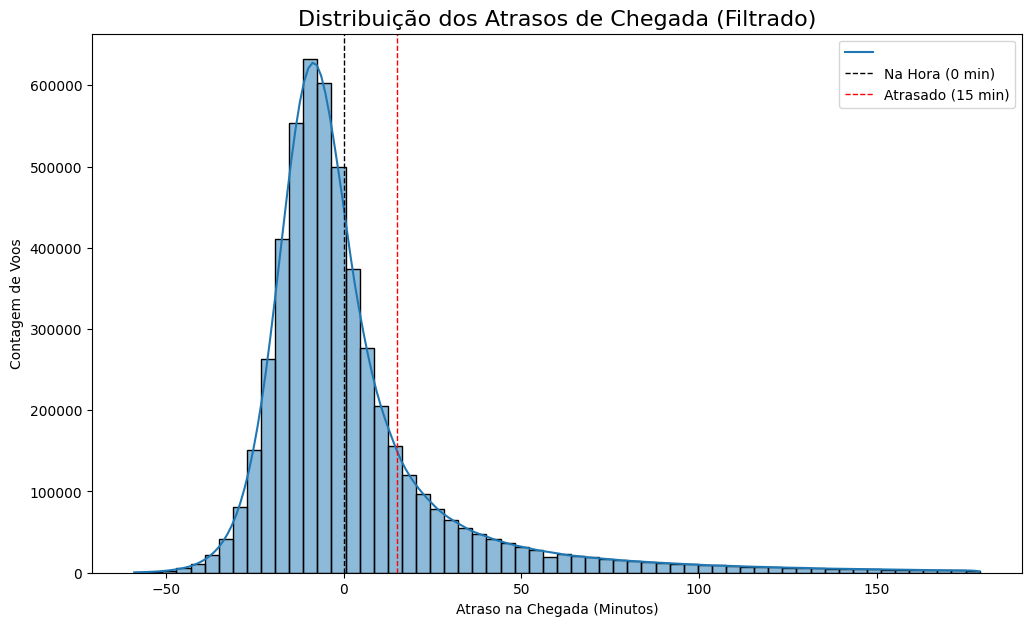

In [34]:
def plot_delay_histogram(data):
    """
    Plota um histograma dos atrasos de chegada (ARRIVAL_DELAY).
    Filtra valores extremos para melhor visualização.
    """

    # Filtra apenas voos não cancelados
    df_non_cancelled = data[data['CANCELLED'] == 0].copy()

    # Filtra valores extremos para visualização
    # (Ex: voos com mais de 3h de atraso ou 1h de adiantamento)
    df_plot = df_non_cancelled[
        (df_non_cancelled['ARRIVAL_DELAY'] > -60) &
        (df_non_cancelled['ARRIVAL_DELAY'] < 180)
    ]

    plt.figure(figsize=(12, 7))
    sns.histplot(df_plot['ARRIVAL_DELAY'], bins=60, kde=True) # kde=True desenha a linha de densidade

    plt.title('Distribuição dos Atrasos de Chegada (Filtrado)', fontsize=16)
    plt.xlabel('Atraso na Chegada (Minutos)')
    plt.ylabel('Contagem de Voos')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Linha no 0
    plt.axvline(x=15, color='red', linestyle='--', linewidth=1)  # Linha de corte (15 min)
    plt.legend(['', 'Na Hora (0 min)', 'Atrasado (15 min)'])
    plt.show()

plot_delay_histogram(df_flights_completo)

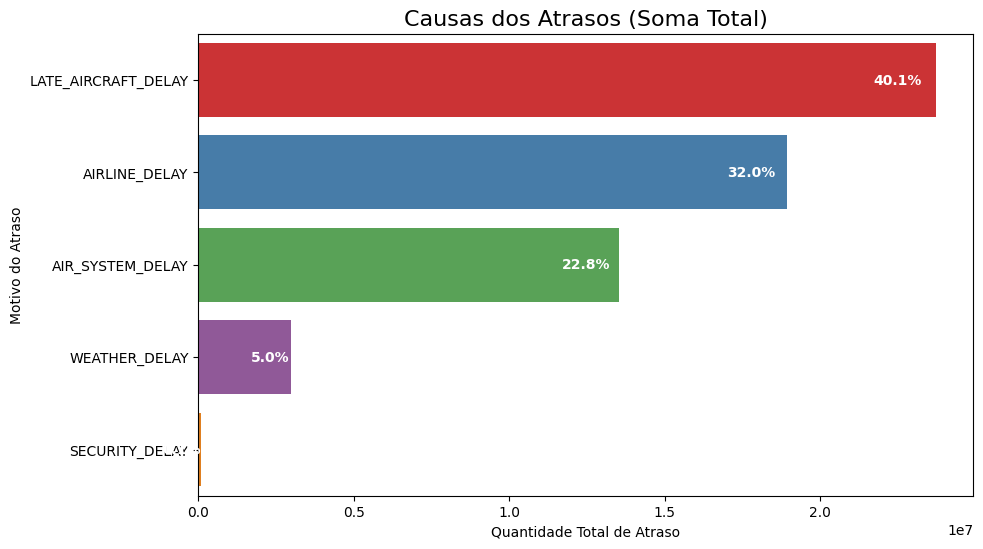

In [35]:
def plot_delay_components(data):
    """
    Plota um gráfico de barras empilhadas mostrando a contribuição
    de cada componente de atraso para o total.
    """

    df_flights_limpo = data.copy()

    delay_types = [
        'AIR_SYSTEM_DELAY',
        'SECURITY_DELAY',
        'AIRLINE_DELAY',
        'LATE_AIRCRAFT_DELAY',
        'WEATHER_DELAY'
    ]

    # Calcular a soma de cada tipo de atraso
    df_delay_sum = data[delay_types].sum().sort_values(ascending=False)

    # Converter para um DataFrame para plotar
    df_plot = df_delay_sum.reset_index()
    df_plot.columns = ['Tipo de Atraso', 'Quantidade Total (Soma)']

    # Calcular porcentagem
    df_plot['Porcentagem'] = (df_plot['Quantidade Total (Soma)'] / df_plot['Quantidade Total (Soma)'].sum()) * 100

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        x='Quantidade Total (Soma)',
        y='Tipo de Atraso',
        palette='Set1'
    )

    plt.title('Causas dos Atrasos (Soma Total)', fontsize=16)
    plt.xlabel('Quantidade Total de Atraso')
    plt.ylabel('Motivo do Atraso')

    # Adicionar labels de porcentagem
    for index, row in df_plot.iterrows():
        plt.text(row['Quantidade Total (Soma)'] * 0.98, index,
                 f"{row['Porcentagem']:.1f}%",
                 color='white', ha='right', va='center', weight='bold')

    plt.show()

plot_delay_components(df_flights_completo)

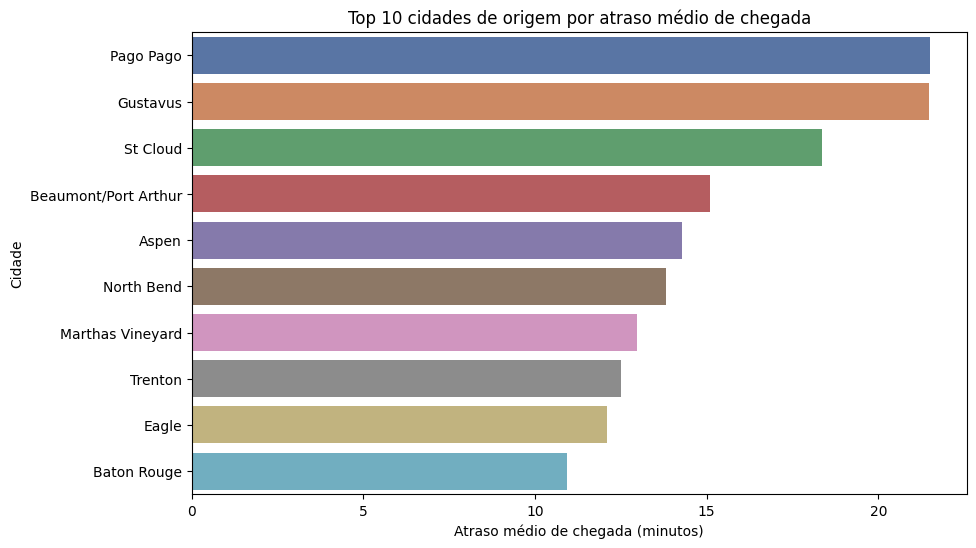

In [36]:
def average_flight_delay_cities(df_flights_completo):
    """
    Plota a média de atraso por cidade de origem (top 10).
    Utiliza a coluna 'ORIGIN_CITY'.
    """
    df_flights_completo = df_flights_completo.copy()

    city_delay = (df_flights_completo.groupby('ORIGIN_CITY')['ARRIVAL_DELAY'].mean()
                  .sort_values(ascending=False).head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=city_delay.values, y=city_delay.index, palette='deep', hue=city_delay.index, legend=False)
    plt.title('Top 10 cidades de origem por atraso médio de chegada')
    plt.xlabel('Atraso médio de chegada (minutos)')
    plt.ylabel('Cidade')
    plt.show()

average_flight_delay_cities(df_flights_completo)

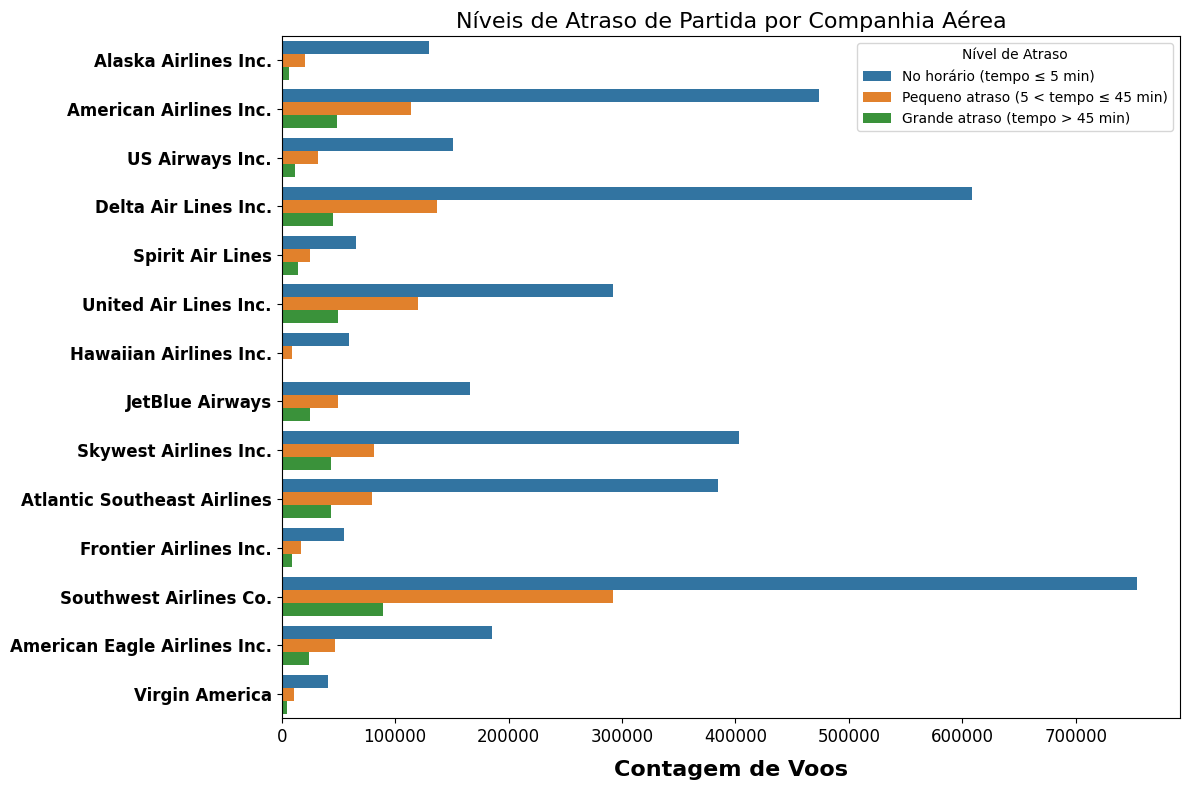

In [37]:
def plot_delay_levels_by_airline(data):
    """
    Cria um gráfico de barras que mostra a contagem de voos por companhia aérea,
    categorizados por níveis de atraso na partida.
    """
    
    # Filtra voos não cancelados para a análise de atrasos
    df_plot = data[data['CANCELLED'] == 0].copy()



    # Função que define como os atrasos são agrupados:
    # 0: no horário (atraso <= 5 min ou adiantado)
    # 1: pequeno atraso (5 < atraso <= 45 min)
    # 2: grande atraso (atraso > 45 min)
    delay_type = lambda x: ((0, 1)[x > 5], 2)[x > 45]
    df_plot['DELAY_LEVEL'] = df_plot['DEPARTURE_DELAY'].apply(delay_type)

    plt.figure(figsize=(12, 8))
    ax = sns.countplot(y="AIRLINE_NAME", hue='DELAY_LEVEL', data=df_plot, palette='tab10')

    plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0)
    plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0)
    ax.yaxis.label.set_visible(False) # Remove o label 'AIRLINE_NAME' do eixo Y
    plt.xlabel('Contagem de Voos', fontsize=16, weight = 'bold', labelpad=10)
    plt.title('Níveis de Atraso de Partida por Companhia Aérea', fontsize=16)

    # Define a legenda
    L = plt.legend(title='Nível de Atraso')
    L.get_texts()[0].set_text('No horário (tempo ≤ 5 min)')
    L.get_texts()[1].set_text('Pequeno atraso (5 < tempo ≤ 45 min)')
    L.get_texts()[2].set_text('Grande atraso (tempo > 45 min)')
    plt.tight_layout()
    plt.show()

plot_delay_levels_by_airline(df_flights_completo)

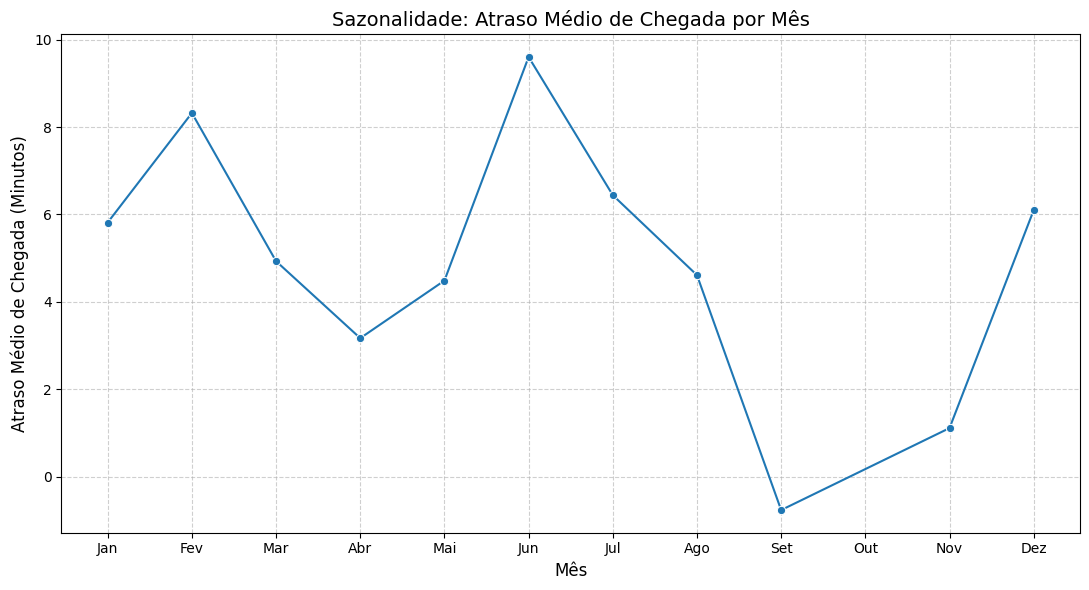

In [38]:
def sazonalidade(data):

  df_non_cancelled = df_flights_completo[df_flights_completo['CANCELLED'] == 0].copy()
  df_non_cancelled['MONTH'] = df_non_cancelled['FLIGHT_DATE'].dt.month

    # Agrupar por mês e calcular o atraso médio
  month_delay = df_non_cancelled.groupby('MONTH')['ARRIVAL_DELAY'].mean()

    # Mapear números dos meses para nomes abreviados
  month_map = {
        1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
        7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
    }
  month_delay.index = month_delay.index.map(month_map)

    # Reordenar
  month_delay = month_delay.reindex(month_map.values())

  plt.figure(figsize=(11, 6))
  # Usar 'lineplot' do seaborn para mostrar a tendência ao longo do tempo
  sns.lineplot(x=month_delay.index, y=month_delay.values, marker='o')
  plt.title('Sazonalidade: Atraso Médio de Chegada por Mês', fontsize=14)
  plt.xlabel('Mês', fontsize=12)
  plt.ylabel('Atraso Médio de Chegada (Minutos)', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6) # Adiciona um grid leve
  plt.tight_layout()
  plt.show()

sazonalidade(df_flights_completo)

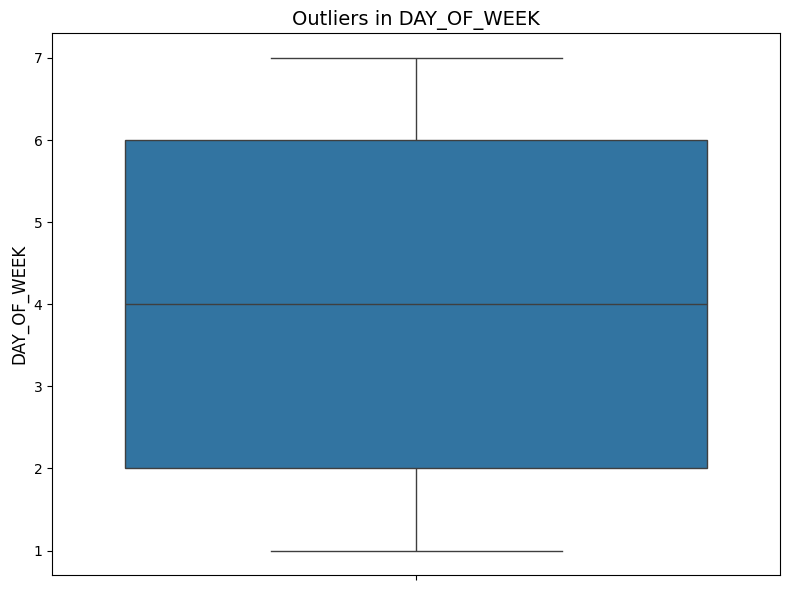

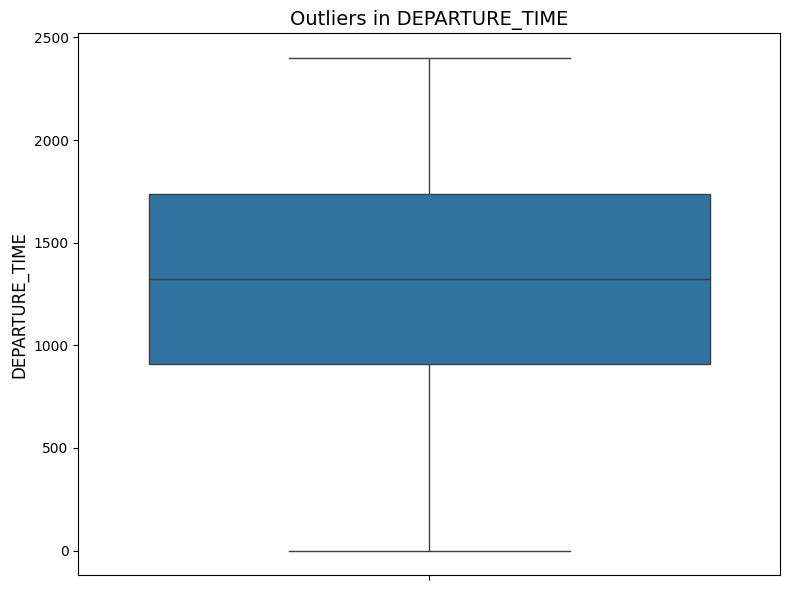

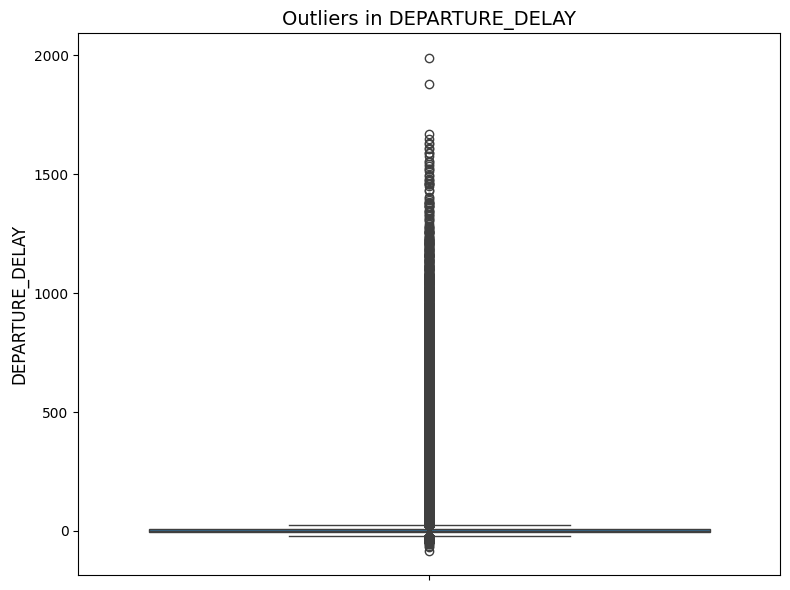

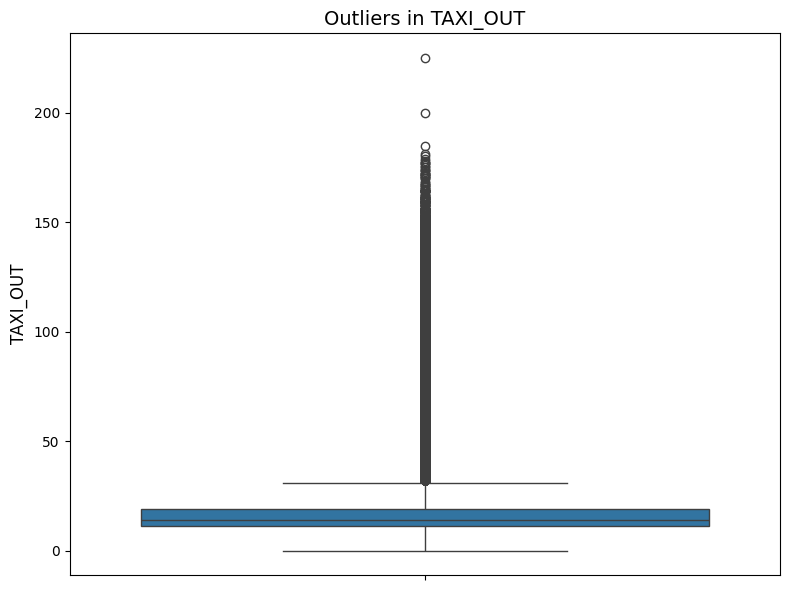

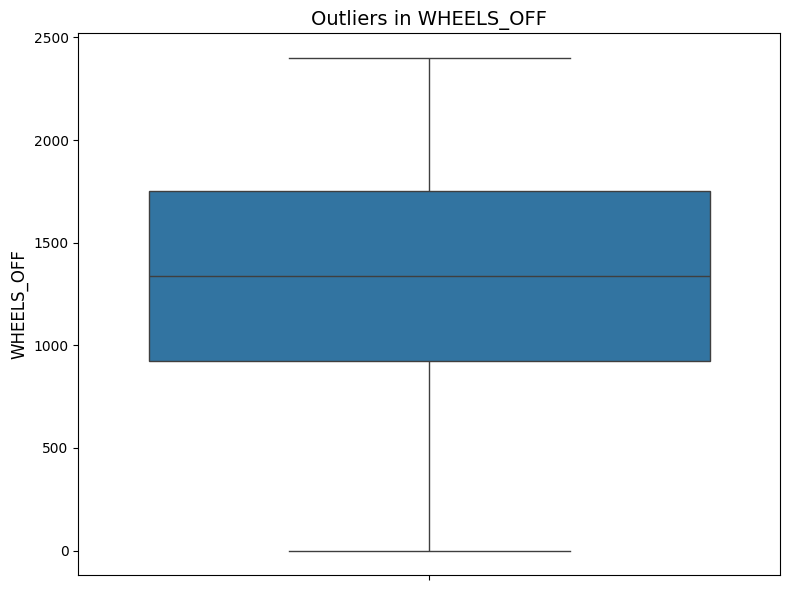

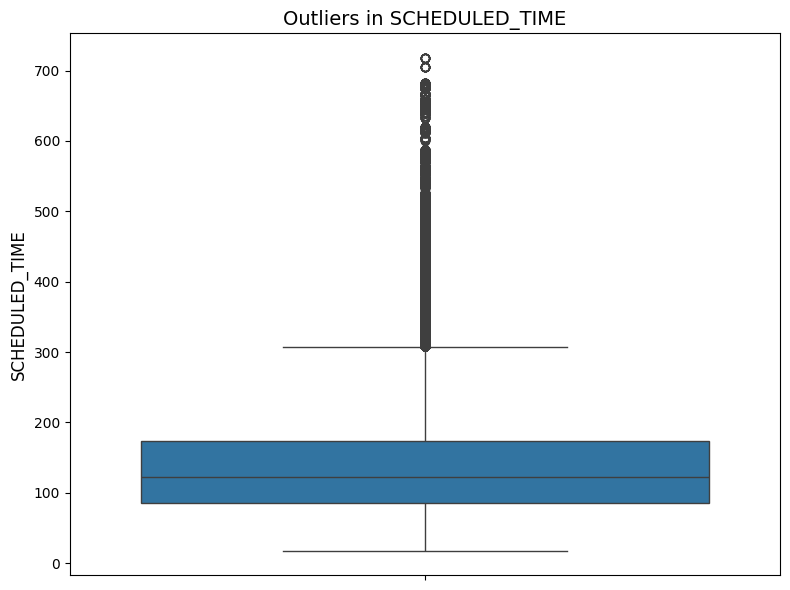

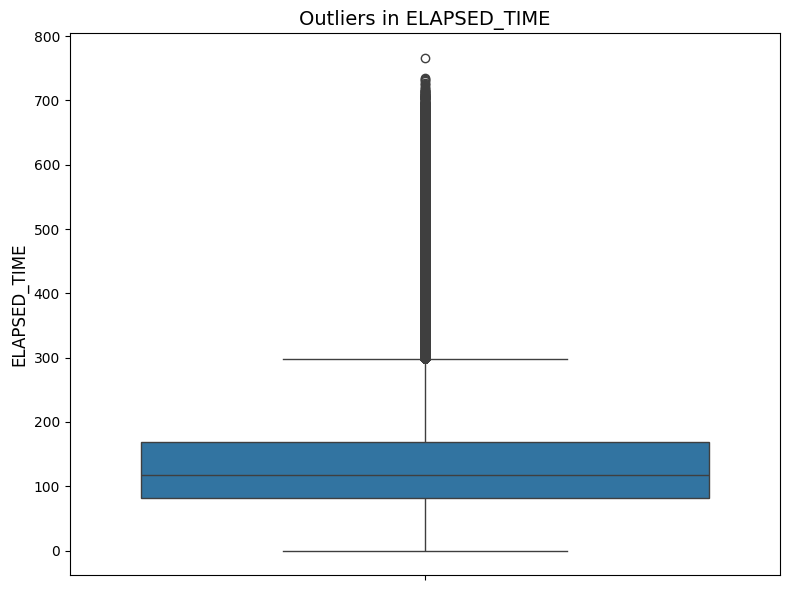

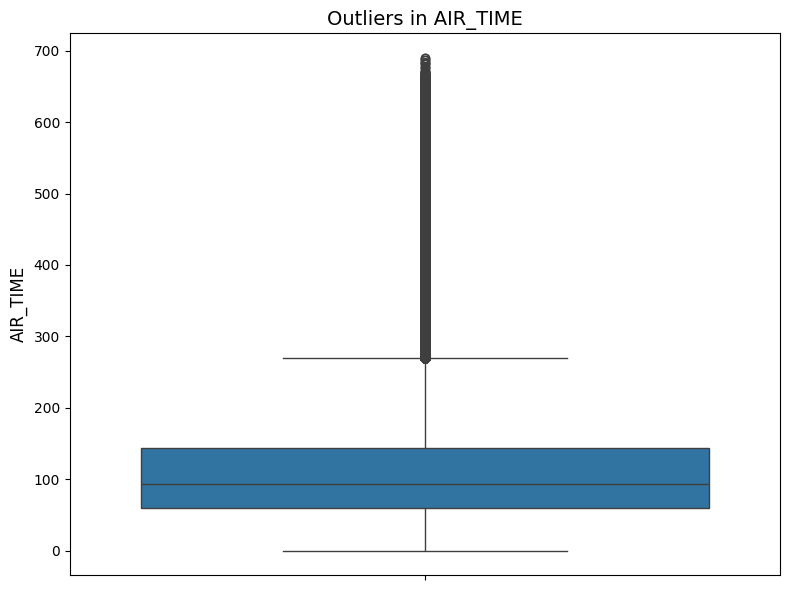

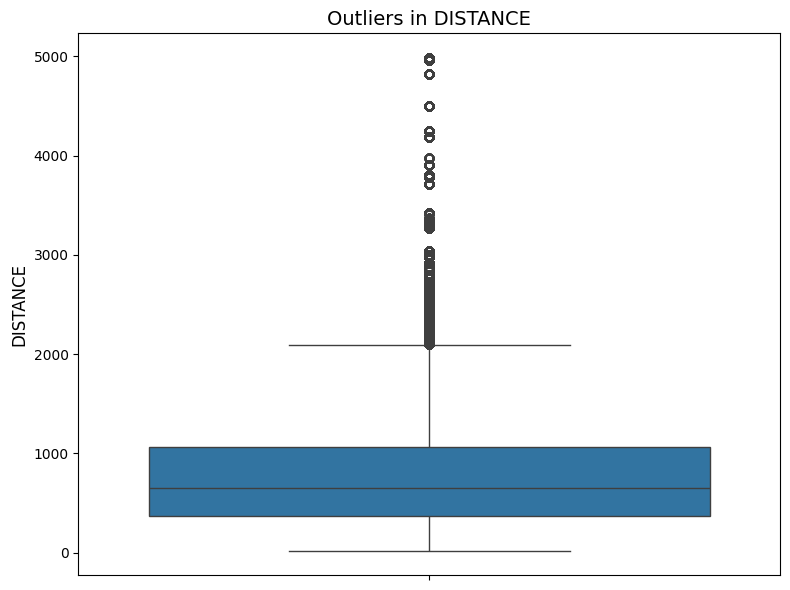

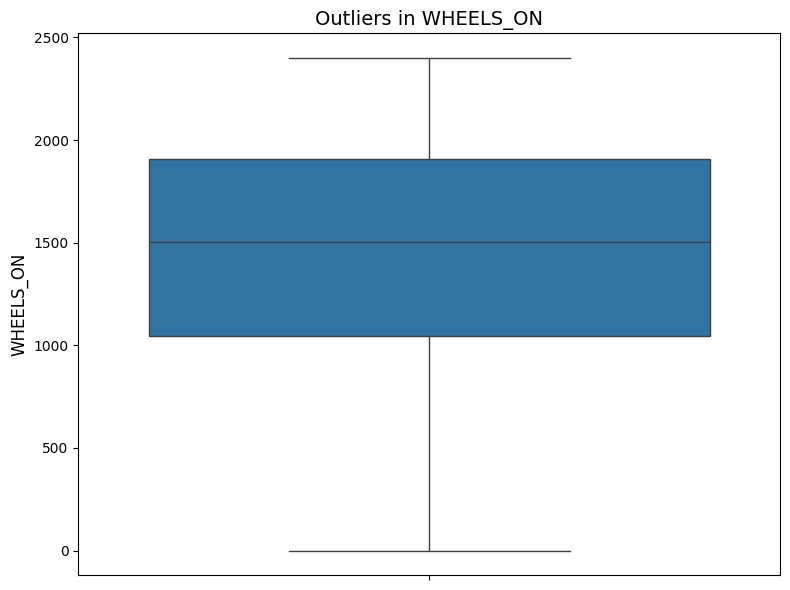

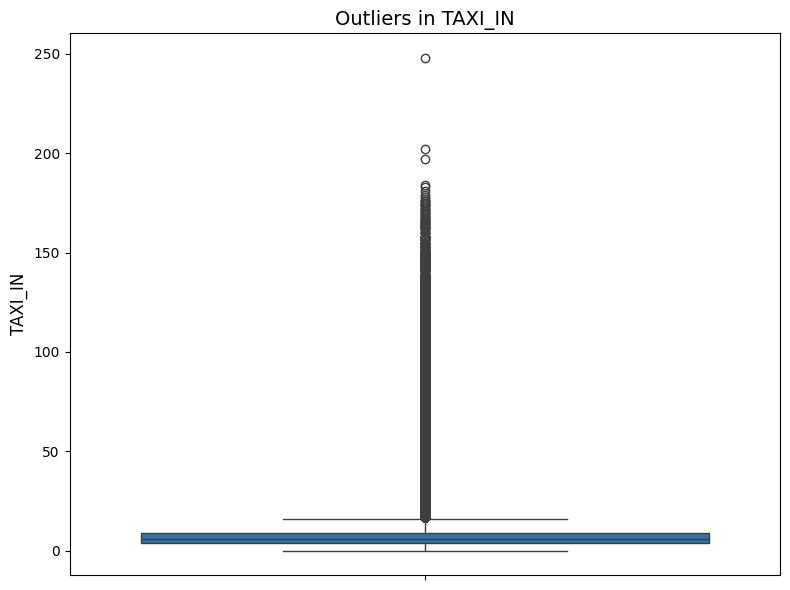

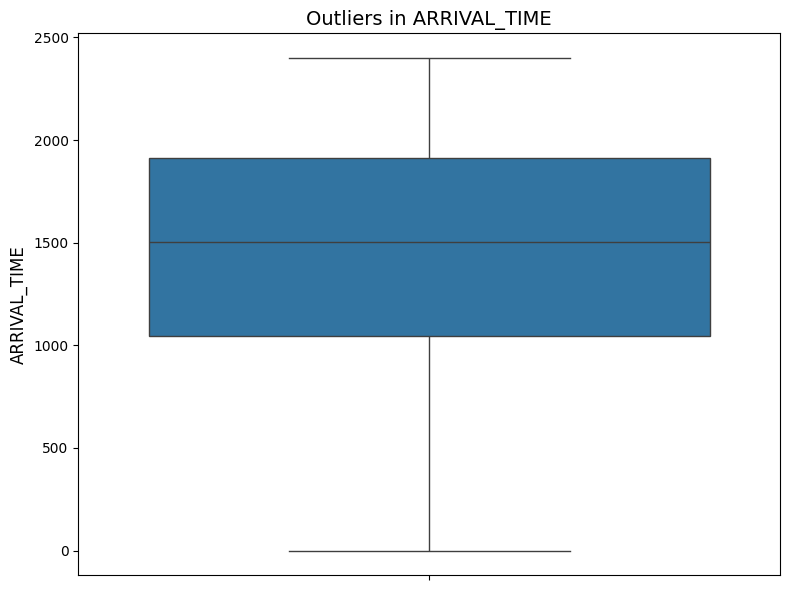

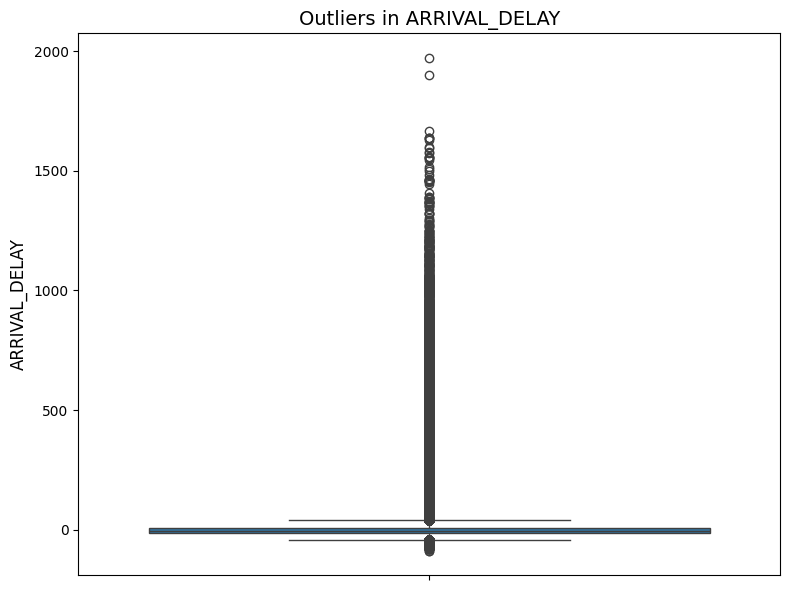

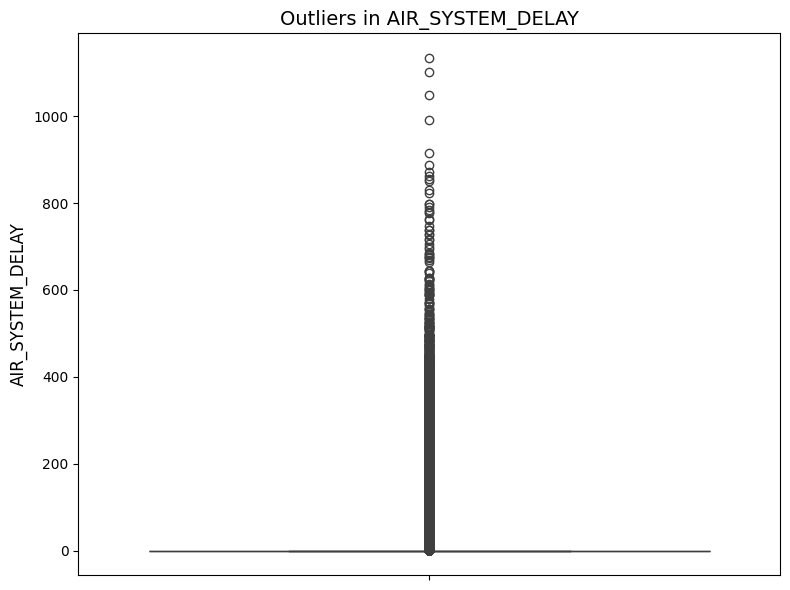

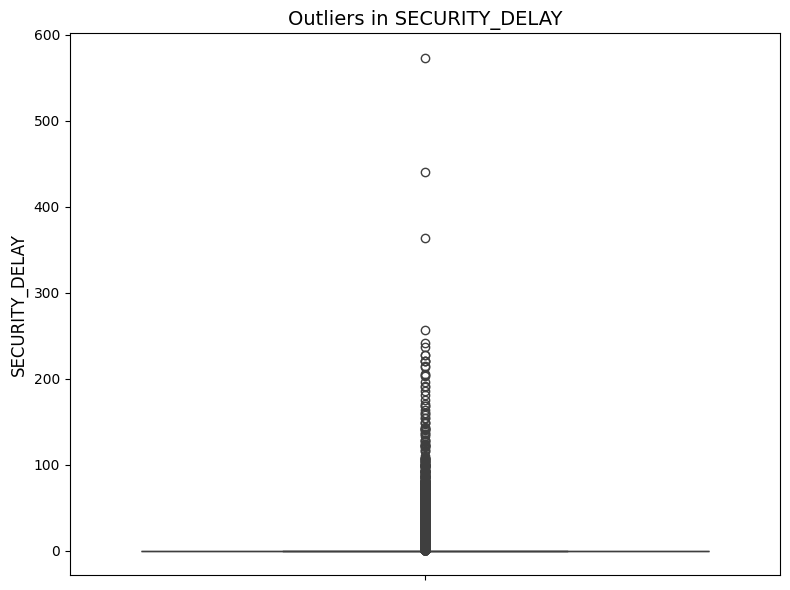

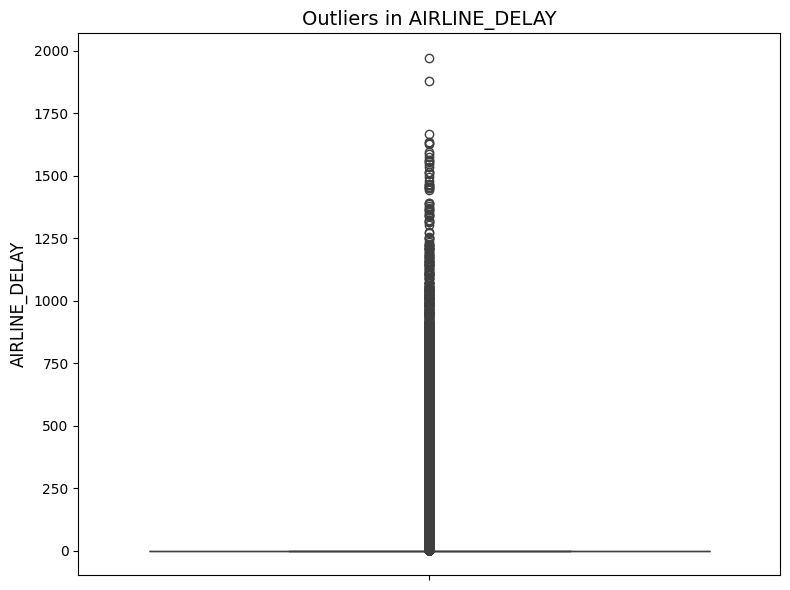

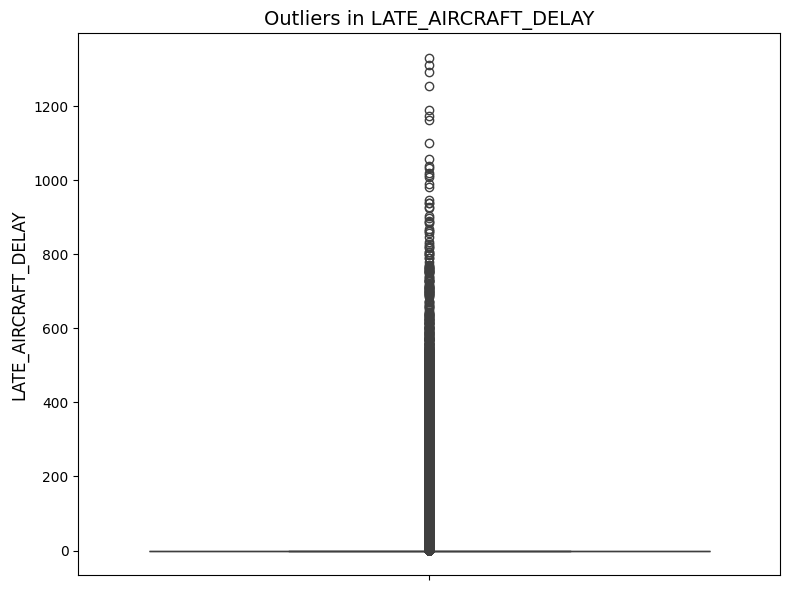

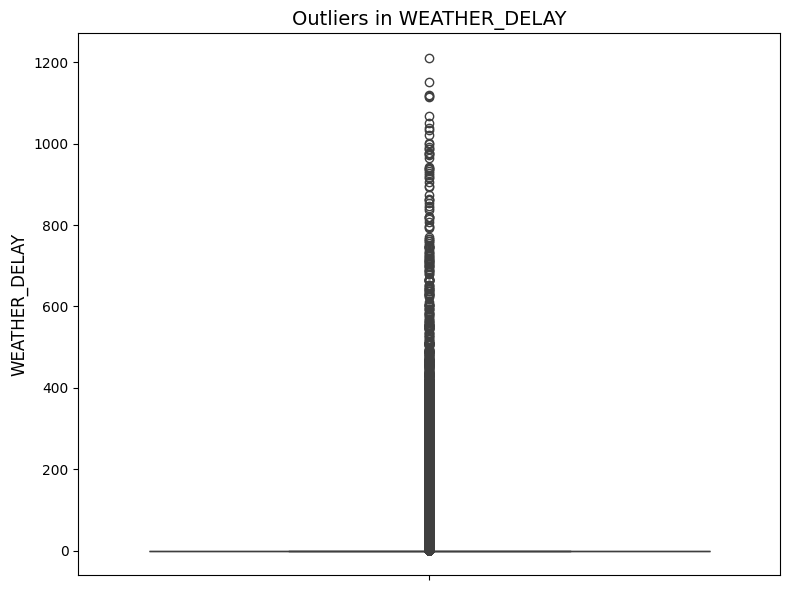

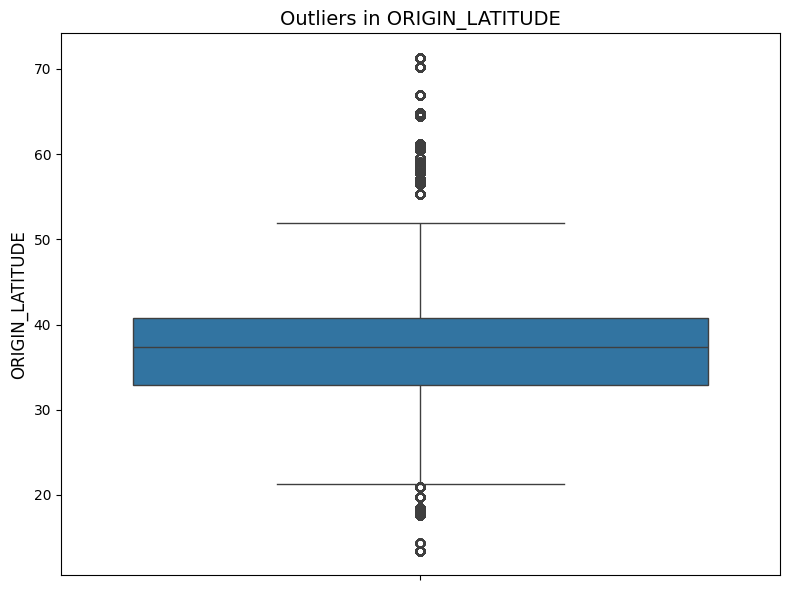

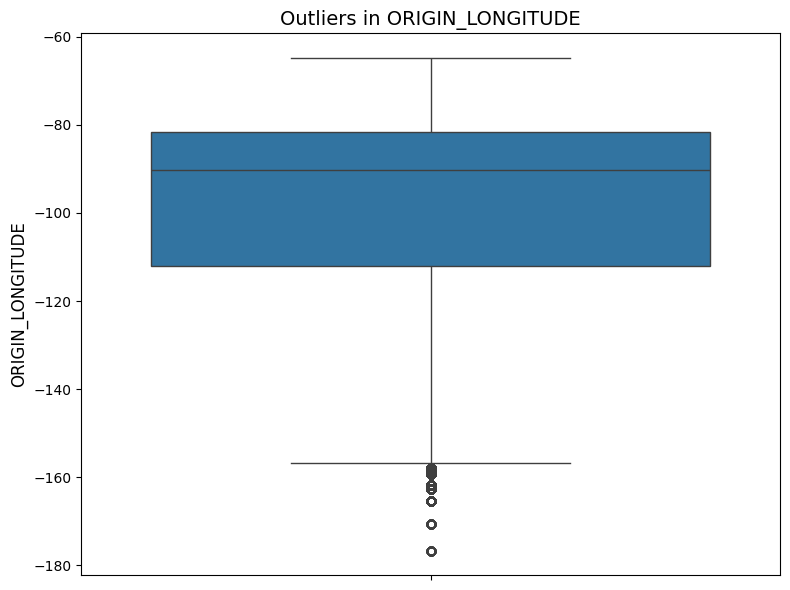

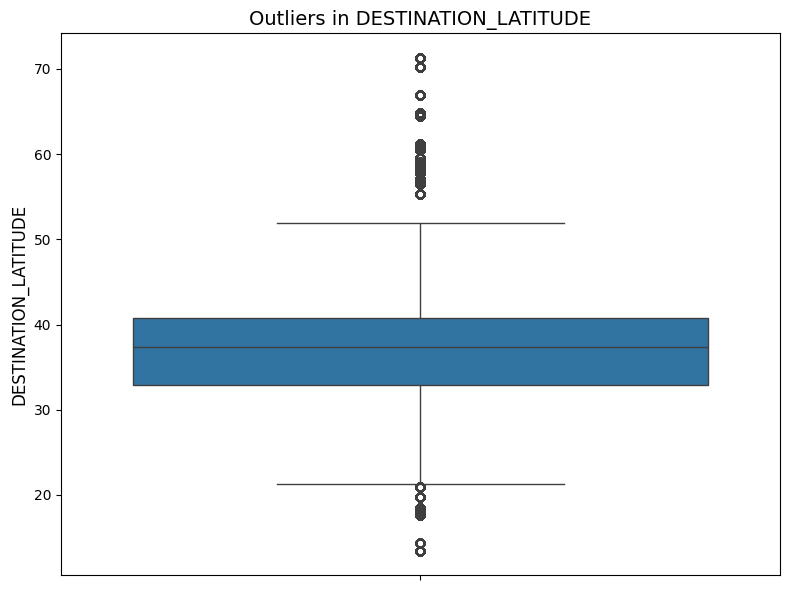

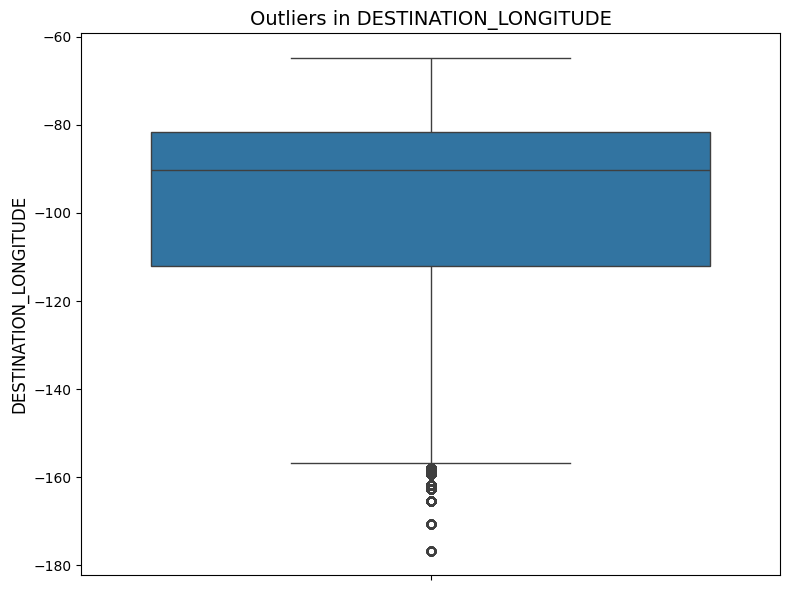

In [39]:
def plot_outliers(data) :
  """
  Plots boxplots de colunas numericas para visualizar outliers.

  """

  df_flights_limpo = data.copy()

  numeric_cols = df_flights_limpo.select_dtypes(include='number').columns.tolist()
  cols_to_remove = ['FLIGHT_NUMBER', 'DIVERTED', 'CANCELLED', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL']
  # Filtrar colunas numéricas, garantindo que as colunas plotadas sejam usados para plotagem real
  plot_cols = [col for col in numeric_cols if col not in cols_to_remove]

  # Loop através das colunas numéricas filtradas e cria um boxplot para cada
  for col in plot_cols:
     plt.figure(figsize=(8, 6))
     sns.boxplot(y=df_flights_limpo[col]) 
     plt.title(f'Outliers in {col}', fontsize=14)
     plt.ylabel(col, fontsize=12)
     plt.tight_layout()
     plt.show()

plot_outliers(df_flights_completo)


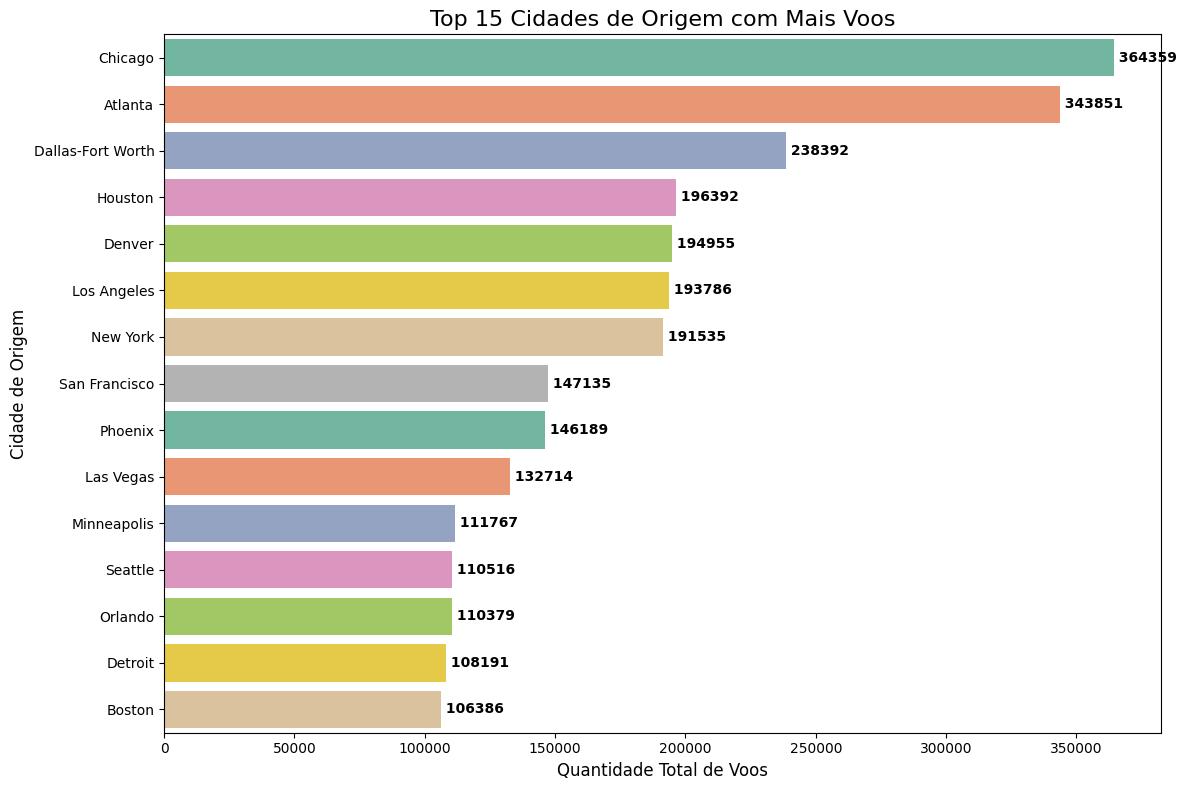

In [40]:
def plot_top_origin_cities(data, top_n=15):
    """
    Plota as cidades de origem com maior volume total de voos com cores diferentes.
    """
    city_counts = data['ORIGIN_CITY'].value_counts().head(top_n)

    plt.figure(figsize=(12, 8))
    
    sns.barplot(x=city_counts.values, y=city_counts.index, palette='Set2') 
    
    plt.title(f'Top {top_n} Cidades de Origem com Mais Voos', fontsize=16)
    plt.xlabel('Quantidade Total de Voos', fontsize=12)
    plt.ylabel('Cidade de Origem', fontsize=12)
    
    for i, v in enumerate(city_counts.values):
        plt.text(v, i, f" {v}", va='center', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

plot_top_origin_cities(df_flights_completo)

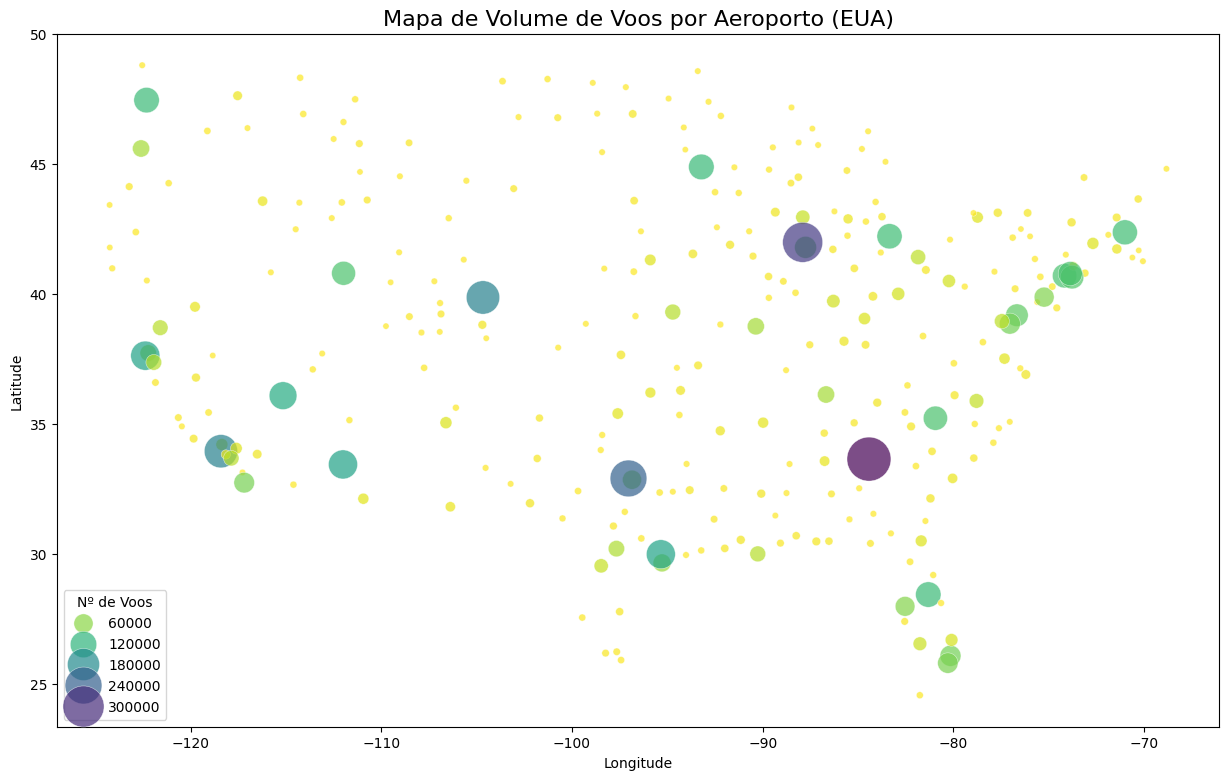

In [41]:
def plot_airport_volume_map(data_flights, data_airports):
    """
    Plota um 'mapa' (scatter plot) de aeroportos.
    O tamanho e a cor dos pontos são baseados no volume de voos.
    """

    # Contar os voos por aeroporto de origem
    count_flights_df = data_flights['ORIGIN_AIRPORT'].value_counts().reset_index()
    count_flights_df.columns = ['IATA_CODE', 'flight_count'] # Renomear colunas

    # Juntar contagem de voos com dados dos aeroportos (Lat/Lon)
    df_map = pd.merge(data_airports, count_flights_df, on='IATA_CODE')

    # Filtrar para os EUA (Continente) ---
    df_plot = df_map.query('24 < LATITUDE < 50 and -130 < LONGITUDE < -65')

    

    plt.figure(figsize=(15, 9))

    sns.scatterplot(
        data=df_plot,
        x='LONGITUDE',
        y='LATITUDE',
        hue='flight_count',   # Cor baseada na contagem (substitui 'colors' e 'ind')
        size='flight_count',  # Tamanho baseado na contagem (substitui 'markersize')

        # Configurações extras
        palette='viridis_r',  # Paleta de cores
        sizes=(20, 1000),     # Define o tamanho mínimo e máximo do ponto
        alpha=0.7             # Transparência
    )

    plt.title('Mapa de Volume de Voos por Aeroporto (EUA)', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.legend(title='Nº de Voos')
    plt.show()

plot_airport_volume_map(df_flights_completo, df_airports)

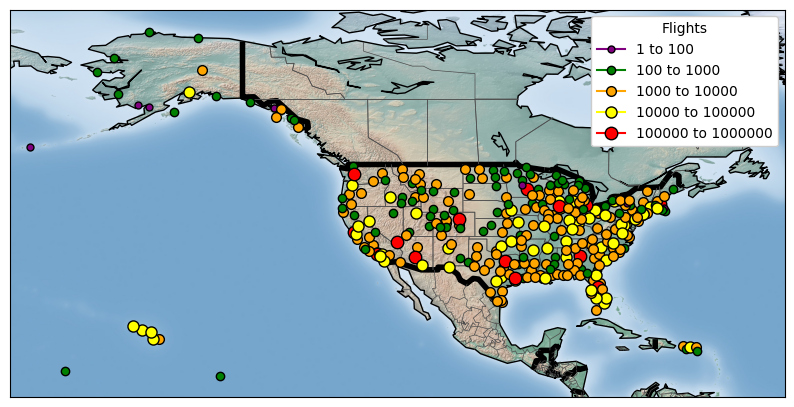

In [42]:
def plotar_mapa_trafego(df_flights, df_airports):
    """
    Gera um mapa visualizando o volume de voos por aeroporto.
    
    Parâmetros:
    df_flights: DataFrame contendo a coluna 'ORIGIN_AIRPORT'.
    df_airports: DataFrame contendo 'IATA_CODE', 'LATITUDE' e 'LONGITUDE'.
    """
    
    # Preparar contagem de voos
    flightcount = df_flights['ORIGIN_AIRPORT'].value_counts()

    plt.figure(figsize=(10,10))

    colors = ['purple', 'green', 'orange', 'yellow', 'red', 'lightblue']
    size = [1, 100, 1000, 10000, 100000, 1000000]
    labels = ["1 to 100", "100 to 1000", "1000 to 10000", "10000 to 100000", "100000 to 1000000"]

    # Configurar o mapa (Basemap)
    m = Basemap(llcrnrlon=-180, urcrnrlon=-50, llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0)
    m.shadedrelief()
    m.drawcoastlines()
    m.drawcountries(linewidth=4)
    m.drawstates(color='0.3')

    # Loop para plotar cada aeroporto
    for index, (code, y, x) in df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
        x_map, y_map = m(x, y) # Converte lat/long para coordenadas do mapa
        
        # Encontra o índice da cor/tamanho baseado na contagem
        # O .get(code, 0) evita erro se o aeroporto não tiver voos na lista
        count = flightcount.get(code, 0)
        isize = [i for i, val in enumerate(size) if val < count]
        
        if isize:
            ind = isize[-1]
            m.plot(x_map, y_map, marker='o', markersize=ind+5, markeredgewidth=1, 
                   color=colors[ind], markeredgecolor='k', label=labels[ind])

    handles, legend_labels = plt.gca().get_legend_handles_labels()
    labels_ord = OrderedDict(zip(legend_labels, handles))
    keys = ('1 to 100', '100 to 1000', '1000 to 10000', '10000 to 100000', '100000 to 1000000')
    
    lnew = OrderedDict()
    for item in keys:
        if item in labels_ord:
            lnew[item] = labels_ord[item]
            
    plt.legend(lnew.values(), lnew.keys(), loc=1, prop={'size':10}, 
               title='Flights', frameon=True, framealpha=1)
    
    plt.show()

plotar_mapa_trafego(df_flights_completo, df_airports)

## Engenharia de Atributos e Preparação para Modelo

In [43]:
def column_outliers_mask(df, col):
    """
    Returns a boolean mask marking outliers in a single numeric column using IQR.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[col] < lower) | (df[col] > upper)

In [44]:
def statistical_features(data):
  df = data.copy()
  stats = {}

  var_numerical = df.select_dtypes(include='number').columns # not index, wanna the columns
  categorical_vars = df.select_dtypes(include=['object','category']).columns

  for col in var_numerical:
    stats[col] = {
        'mean' : df[col].mean(),
        'std' : df[col].std(),
        'median' : df[col].median(),
        'var' : df[col].var()
    }

    stats_df = pd.DataFrame(stats).T # Transpose matrix to be more readable

  return stats_df

df_stats = statistical_features(df_flights_completo)

df_stats

,mean,std,median,var
DAY_OF_WEEK,3.92,1.99,4.00,3.97
FLIGHT_NUMBER,2180.42,1762.03,1691.00,3104739.10
SCHEDULED_DEPARTURE,1330.26,484.32,1325.00,234565.67
DEPARTURE_TIME,1318.56,517.02,1324.00,267313.59
DEPARTURE_DELAY,9.61,37.26,-1.00,1388.16
TAXI_OUT,15.88,9.11,14.00,83.03
WHEELS_OFF,1339.40,520.10,1336.00,270499.23
SCHEDULED_TIME,141.75,75.23,123.00,5659.04
ELAPSED_TIME,135.38,75.53,117.00,5704.38
AIR_TIME,112.17,73.04,93.00,5334.56


In [45]:
def outliers_detection_and_removal(data):
  """Detecta e remove outliers usando o método IQR - modelagem."""

  df = data.copy()
  size_df = len(df)

  var_numerical = df.select_dtypes(include='number').columns
  outliers_info = {}

  # Inicializa a máscara de outliers
  outliers_mask = pd.Series(False, index=df.index)

  for col in var_numerical:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bounder = Q1 - 1.5 * IQR
    upper_bounder = Q3 + 1.5 * IQR

    mask = (df[col] < lower_bounder) | (df[col] > upper_bounder)
    outliers_mask |= mask # Atualiza a máscara cumulativa para outliers

    outliers_info[col] = {
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR' : IQR,
        'Lower Bounder' : lower_bounder,
        'Upper Bounder' : upper_bounder,
        'Count' : mask.sum(),
        'Outliers percent' : mask.sum()/size_df * 100
        }

  # Cria o DataFrame de informações de outliers e o DataFrame limpo FORA do loop
  df_outliers_info = pd.DataFrame(outliers_info).T
  df_outliers = df[~outliers_mask] # Filtra o DataFrame original usando a máscara cumulativa

  return df_outliers_info , df_outliers

df_out_info, df_cleaned = outliers_detection_and_removal(df_flights_completo)

In [46]:
df_out_info

,Q1,Q3,IQR,Lower Bounder,Upper Bounder,Count,Outliers percent
DAY_OF_WEEK,2.00,6.00,4.00,-4.00,12.00,0.00,0.00
FLIGHT_NUMBER,731.00,3257.00,2526.00,-3058.00,7046.00,24766.00,0.47
SCHEDULED_DEPARTURE,917.00,1730.00,813.00,-302.50,2949.50,0.00,0.00
DEPARTURE_TIME,910.00,1738.00,828.00,-332.00,2980.00,0.00,0.00
DEPARTURE_DELAY,-5.00,7.00,12.00,-23.00,25.00,691745.00,13.06
TAXI_OUT,11.00,19.00,8.00,-1.00,31.00,262543.00,4.96
WHEELS_OFF,925.00,1752.00,827.00,-315.50,2992.50,0.00,0.00
SCHEDULED_TIME,85.00,174.00,89.00,-48.50,307.50,266435.00,5.03
ELAPSED_TIME,81.00,168.00,87.00,-49.50,298.50,263120.00,4.97
AIR_TIME,59.00,143.00,84.00,-67.00,269.00,275541.00,5.20


In [47]:
df_cleaned.describe()

,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,FLIGHT_DATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
count,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998.00,3516998,3516998.00,3516998.00,3516998.00,3516998.00
mean,3.94,2283.29,1291.80,1286.54,-1.25,14.40,1308.70,127.51,120.32,99.45,707.51,1446.54,6.47,1463.67,1452.88,-8.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-06-24 06:57:35.572053504,36.72,-94.39,36.79,-94.09
min,1.00,1.00,1.00,1.00,-23.00,1.00,1.00,30.00,16.00,8.00,62.00,1.00,1.00,1.00,1.00,-44.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-01-01 00:00:00,24.56,-124.25,24.56,-124.25
25%,2.00,841.00,900.00,857.00,-5.00,11.00,911.00,85.00,79.00,59.00,369.00,1042.00,4.00,1055.00,1046.00,-15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-03-30 00:00:00,33.37,-104.67,33.43,-104.67
50%,4.00,1816.00,1250.00,1249.00,-3.00,13.00,1301.00,116.00,110.00,88.00,606.00,1434.00,6.00,1445.00,1438.00,-8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-06-19 00:00:00,36.20,-90.26,37.24,-89.98
75%,6.00,3415.00,1704.00,1702.00,1.00,17.00,1716.00,160.00,152.00,131.00,965.00,1838.00,8.00,1848.00,1842.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-09-09 00:00:00,40.79,-82.53,40.79,-81.85
max,7.00,6899.00,2359.00,2400.00,25.00,31.00,2400.00,307.00,298.00,269.00,2092.00,2400.00,16.00,2359.00,2400.00,14.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-12-31 00:00:00,48.79,-68.83,48.79,-68.83
std,1.99,1729.54,478.36,481.71,6.67,5.27,481.75,53.89,52.33,51.48,432.19,490.70,3.01,493.92,492.91,10.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,5.18,15.26,5.17,15.25


In [48]:
df_cleaned.head()

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_NAME,FLIGHT_DATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,ORIGIN_CITY,ORIGIN_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE
5,4,DL,806,N3730B,SFO,MSP,25,20,-5,18,38,217,230,206,1589,604,6,602,610,8,0,0,0,0,0,0,0,0,DL,Delta Air Lines Inc.,2015-01-01,37.62,-122.37,San Francisco,CA,44.88,-93.22,Minneapolis,MN
6,4,NK,612,N635NK,LAS,MSP,25,19,-6,11,30,181,170,154,1299,504,5,526,509,-17,0,0,0,0,0,0,0,0,NK,Spirit Air Lines,2015-01-01,36.08,-115.15,Las Vegas,NV,44.88,-93.22,Minneapolis,MN
8,4,AA,1112,N3LAAA,SFO,DFW,30,19,-11,17,36,195,193,173,1464,529,3,545,532,-13,0,0,0,0,0,0,0,0,AA,American Airlines Inc.,2015-01-01,37.62,-122.37,San Francisco,CA,32.90,-97.04,Dallas-Fort Worth,TX
9,4,DL,1173,N826DN,LAS,ATL,30,33,3,12,45,221,203,186,1747,651,5,711,656,-15,0,0,0,0,0,0,0,0,DL,Delta Air Lines Inc.,2015-01-01,36.08,-115.15,Las Vegas,NV,33.64,-84.43,Atlanta,GA
10,4,DL,2336,N958DN,DEN,ATL,30,24,-6,12,36,173,149,133,1199,449,4,523,453,-30,0,0,0,0,0,0,0,0,DL,Delta Air Lines Inc.,2015-01-01,39.86,-104.67,Denver,CO,33.64,-84.43,Atlanta,GA


In [49]:
def get_part_of_day(time_int):
    """Converte um horário HHMM (int) em uma categoria de período do dia."""
    # Garante que é um inteiro
    time_int = int(time_int)

    if 500 <= time_int <= 1159:
        return 'Manhã' # (5:00 - 11:59)
    elif 1200 <= time_int <= 1759:
        return 'Tarde' # (12:00 - 17:59)
    elif 1800 <= time_int <= 2259:
        return 'Noite' # (18:00 - 22:59)
    else:
        return 'Madrugada' # (23:00 - 4:59)

In [50]:
# Aplicando a função para criar a nova coluna
df_cleaned['PART_OF_DAY_DEPARTURE'] = df_cleaned['SCHEDULED_DEPARTURE'].apply(get_part_of_day)
df_cleaned['PART_OF_DAY_ARRIVAL'] = df_cleaned['SCHEDULED_ARRIVAL'].apply(get_part_of_day)

In [51]:
df_cleaned['DELAY_DISTANCE_RATIO'] = df_cleaned['DEPARTURE_DELAY'] / (df_cleaned['DISTANCE'])
df_cleaned['ROUTE'] = df_cleaned['ORIGIN_AIRPORT'].astype(str) + '_' + df_cleaned['DESTINATION_AIRPORT'].astype(str)
df_cleaned['PLANNED_SPEED'] = df_cleaned['DISTANCE'] / (df_cleaned['SCHEDULED_TIME'] / 60)  # Velocidade planejada em milhas por hora
df_cleaned['MONTH'] = df_cleaned['FLIGHT_DATE'].dt.month.astype(str)
df_cleaned['ARRIVAL_DELAY'] = (df_cleaned['ARRIVAL_DELAY'] > 0).astype(int)
df_cleaned = df_cleaned[(df_cleaned['CANCELLED'] == 0) & (df_cleaned['DIVERTED'] == 0)]

In [52]:
colunas_para_manter = [
    # Variáveis Temporais (Conhecidas no agendamento)
    'MONTH',
    'DAY_OF_WEEK',
    'PART_OF_DAY_DEPARTURE',
    'PART_OF_DAY_ARRIVAL',
    'ORIGIN_AIRPORT', 
    'DESTINATION_AIRPORT',

    # Variáveis Categóricas (Quem e Onde)
    'AIRLINE',         # Código da companhia
    'ORIGIN_STATE',  # Onde sai
    'DESTINATION_STATE', # Para onde vai

    # Variáveis Numéricas (Planejamento do voo)
    'DISTANCE',        # Distância é fixa
    'SCHEDULED_TIME',  # Tempo planejado de voo (não o real)
    'DEPARTURE_DELAY', # Atraso na partida
    'TAXI_OUT',       # Tempo de taxiamento na saída

    'DELAY_DISTANCE_RATIO',
    'PLANNED_SPEED',
    'ROUTE',

    # Variável Alvo (Target)
    'ARRIVAL_DELAY'

]

df_cleaned = df_cleaned[colunas_para_manter].copy()

In [53]:
df_cleaned.head()

,MONTH,DAY_OF_WEEK,PART_OF_DAY_DEPARTURE,PART_OF_DAY_ARRIVAL,ORIGIN_AIRPORT,DESTINATION_AIRPORT,AIRLINE,ORIGIN_STATE,DESTINATION_STATE,DISTANCE,SCHEDULED_TIME,DEPARTURE_DELAY,TAXI_OUT,DELAY_DISTANCE_RATIO,PLANNED_SPEED,ROUTE,ARRIVAL_DELAY
5,1,4,Madrugada,Manhã,SFO,MSP,DL,CA,MN,1589,217,-5,18,-0.00,439.35,SFO_MSP,1
6,1,4,Madrugada,Manhã,LAS,MSP,NK,NV,MN,1299,181,-6,11,-0.00,430.61,LAS_MSP,0
8,1,4,Madrugada,Manhã,SFO,DFW,AA,CA,TX,1464,195,-11,17,-0.01,450.46,SFO_DFW,0
9,1,4,Madrugada,Manhã,LAS,ATL,DL,NV,GA,1747,221,3,12,0.00,474.30,LAS_ATL,0
10,1,4,Madrugada,Manhã,DEN,ATL,DL,CO,GA,1199,173,-6,12,-0.01,415.84,DEN_ATL,0


In [54]:
cols_to_encode = ['DAY_OF_WEEK','MONTH','PART_OF_DAY_DEPARTURE','PART_OF_DAY_ARRIVAL','AIRLINE']
numerical_cols = ['DISTANCE','SCHEDULED_TIME','DEPARTURE_DELAY','TAXI_OUT','DELAY_DISTANCE_RATIO','PLANNED_SPEED']
frequency_encoder_cols = ['ORIGIN_AIRPORT',  'DESTINATION_AIRPORT','ORIGIN_STATE', 'DESTINATION_STATE','ROUTE']

In [55]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False), cols_to_encode),
        ('cat_freq', CountEncoder(normalize=True, handle_unknown=0,combine_min_nan_groups=True), frequency_encoder_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [56]:
df_cleaned.head()

,MONTH,DAY_OF_WEEK,PART_OF_DAY_DEPARTURE,PART_OF_DAY_ARRIVAL,ORIGIN_AIRPORT,DESTINATION_AIRPORT,AIRLINE,ORIGIN_STATE,DESTINATION_STATE,DISTANCE,SCHEDULED_TIME,DEPARTURE_DELAY,TAXI_OUT,DELAY_DISTANCE_RATIO,PLANNED_SPEED,ROUTE,ARRIVAL_DELAY
5,1,4,Madrugada,Manhã,SFO,MSP,DL,CA,MN,1589,217,-5,18,-0.00,439.35,SFO_MSP,1
6,1,4,Madrugada,Manhã,LAS,MSP,NK,NV,MN,1299,181,-6,11,-0.00,430.61,LAS_MSP,0
8,1,4,Madrugada,Manhã,SFO,DFW,AA,CA,TX,1464,195,-11,17,-0.01,450.46,SFO_DFW,0
9,1,4,Madrugada,Manhã,LAS,ATL,DL,NV,GA,1747,221,3,12,0.00,474.30,LAS_ATL,0
10,1,4,Madrugada,Manhã,DEN,ATL,DL,CO,GA,1199,173,-6,12,-0.01,415.84,DEN_ATL,0


## Modelagem Supervisionada (Machine Learning - Classificação)

Classificação: prever se um voo vai atrasar ou não.

In [57]:
models_dict = {
    'LightGBM': lgb.LGBMClassifier(verbosity=-1, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

In [58]:
def model_traning(models_dict:dict,data:pd.DataFrame,test_size:int):

  '''
  Model training and evaluation function
  '''

  df = data.copy()

  X = df.drop('ARRIVAL_DELAY',axis=1)
  y = df['ARRIVAL_DELAY']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

  X_train = preprocessor.fit_transform(X_train)
  X_test = preprocessor.transform(X_test)


  results = {}


  print('=' * 50)
  print(f'X train shape : {X_train.shape}')
  print(f'Y train shape : {y_train.shape}')
  print(f'X test shape : {X_test.shape}')
  print(f'Y test shape : {y_test.shape}')
  print('=' * 50)

  for name , model in models_dict.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    acc_score = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='binary')
    recall = recall_score(y_test,y_pred,average='binary')
    f1 = f1_score(y_test,y_pred,average='binary')

    print(f'Model training : {name}')

    print('--- Model metrics ---')
    print(f'Accuracy : {acc_score:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall : {recall:.4f}')
    print(f'F1 score : {f1:.4f}')

    results[name] = {
        'accuracy' : acc_score,
        'precision' : precision,
        'recall' : recall,
        'f1_score': f1
    }

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

  return results, X_train, X_test, y_train, y_test

In [59]:
def model_training_kfold(models_dict: dict, data: pd.DataFrame, n_splits: int = 5):
    '''
    Model training and evaluation function using Stratified K-Fold Cross Validation
    '''

    df = data.copy()

    X = df.drop('ARRIVAL_DELAY', axis=1)
    y = df['ARRIVAL_DELAY']

    # Configuração do K-Fold Estratificado (mantém a proporção das classes)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {}

    print('=' * 50)
    print(f'Iniciando Validação Cruzada com {n_splits} folds...')
    print(f'Total de amostras: {X.shape[0]}')
    print('=' * 50)

    for name, model in models_dict.items():
        print(f'\nTreinando modelo: {name} ...')

        # CRUCIAL: Criamos um Pipeline.
        # O preprocessor (definido globalmente) vai rodar APENAS nos dados de treino de cada fold.
        # Isso evita Data Leakage.
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), # Usa o seu preprocessor existente
            ('model', model)
        ])

        # Obter Métricas (Média dos Folds)
        # Definimos as métricas que queremos calcular
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        
        cv_results = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)

        # Calculamos as médias e desvios padrão
        acc_mean = cv_results['test_accuracy'].mean()
        prec_mean = cv_results['test_precision'].mean()
        rec_mean = cv_results['test_recall'].mean()
        f1_mean = cv_results['test_f1'].mean()

        print(f'--- Model Metrics (Média de {n_splits} folds) ---')
        print(f'Accuracy : {acc_mean:.4f} (+/- {cv_results["test_accuracy"].std():.4f})')
        print(f'Precision: {prec_mean:.4f}')
        print(f'Recall   : {rec_mean:.4f}')
        print(f'F1 Score : {f1_mean:.4f}')

        results[name] = {
            'accuracy': acc_mean,
            'precision': prec_mean,
            'recall': rec_mean,
            'f1_score': f1_mean,
            'cv_raw_results': cv_results # Guardamos os dados brutos se precisar depois
        }

        # Matriz de Confusão Global
        # O cross_val_predict gera predições para cada ponto quando ele esteve no conjunto de teste
        y_pred_global = cross_val_predict(model_pipeline, X, y, cv=cv)

        cm = confusion_matrix(y, y_pred_global)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão (Cross-Validation): {name}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.show()

    # Na validação cruzada não retornamos X_train/X_test fixos, pois eles mudam a cada fold.
    return results

In [ ]:
df_cleaned_sampled = df_cleaned.sample(frac=0.05, random_state=42)
print(f"Tamanho original do dataset: {df_cleaned.shape}")
print(f"Tamanho do dataset amostrado (5%): {df_cleaned_sampled.shape}") # 5%, ou seja, 175 mil linhas para treino e teste rápido
df_cleaned = df_cleaned_sampled.copy()

Tamanho original do dataset: (3516998, 17)
Tamanho do dataset amostrado (5%): (175850, 17)


Avaliação de Resultados

X train shape : (123095, 50)
Y train shape : (123095,)
X test shape : (52755, 50)
Y test shape : (52755,)
Model training : LightGBM
--- Model metrics ---
Accuracy : 0.8737
Precision : 0.7551
Recall : 0.5165
F1 score : 0.6134


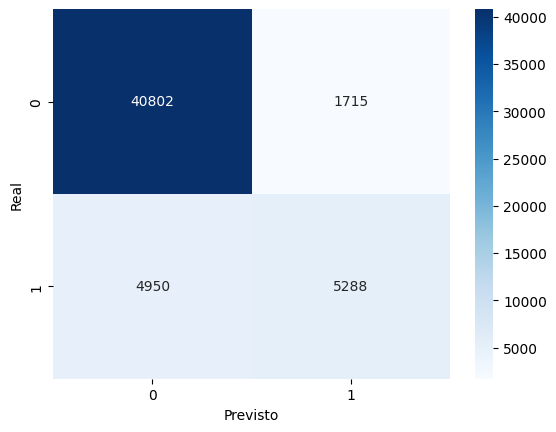

Model training : RandomForest
--- Model metrics ---
Accuracy : 0.8663
Precision : 0.7576
Recall : 0.4577
F1 score : 0.5707


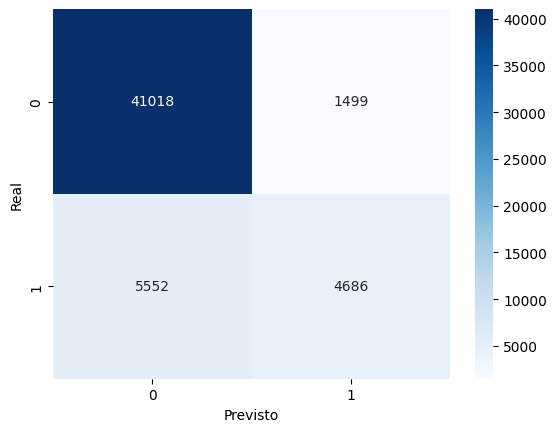

Model training : XGBoost
--- Model metrics ---
Accuracy : 0.8741
Precision : 0.7500
Recall : 0.5272
F1 score : 0.6191


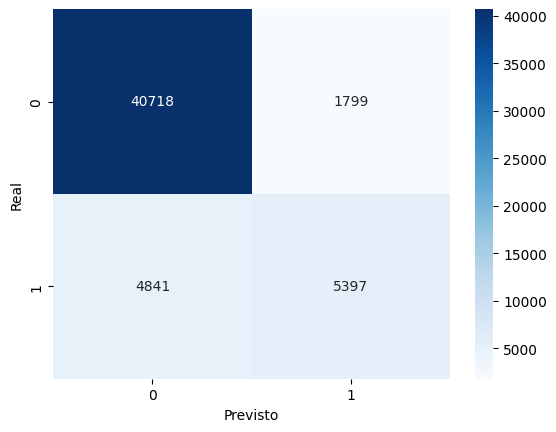

Model training : SGDClassifier
--- Model metrics ---
Accuracy : 0.8676
Precision : 0.7309
Recall : 0.5026
F1 score : 0.5956


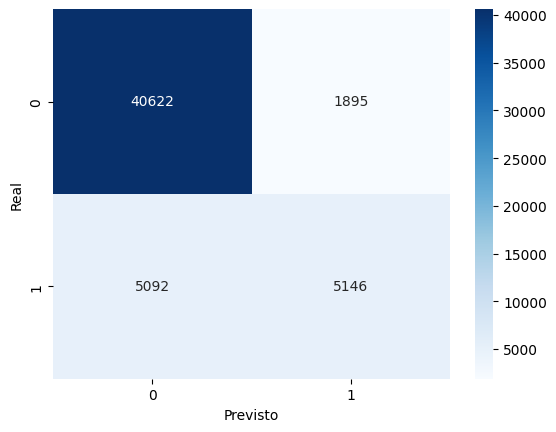

Model training : LogisticRegression
--- Model metrics ---
Accuracy : 0.8690
Precision : 0.7477
Recall : 0.4905
F1 score : 0.5924


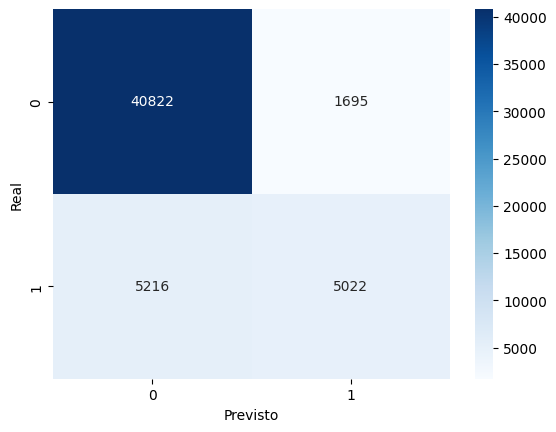

Model training : DecisionTree
--- Model metrics ---
Accuracy : 0.8049
Precision : 0.4975
Recall : 0.5133
F1 score : 0.5053


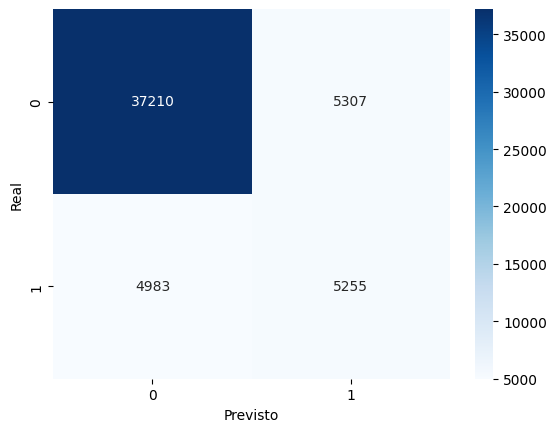

,DISTANCE,SCHEDULED_TIME,DEPARTURE_DELAY,TAXI_OUT,DELAY_DISTANCE_RATIO,PLANNED_SPEED,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,MONTH_1,MONTH_11,MONTH_12,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,PART_OF_DAY_DEPARTURE_Madrugada,PART_OF_DAY_DEPARTURE_Manhã,PART_OF_DAY_DEPARTURE_Noite,PART_OF_DAY_DEPARTURE_Tarde,PART_OF_DAY_ARRIVAL_Madrugada,PART_OF_DAY_ARRIVAL_Manhã,PART_OF_DAY_ARRIVAL_Noite,PART_OF_DAY_ARRIVAL_Tarde,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ORIGIN_STATE,DESTINATION_STATE,ROUTE
1973778,-0.26,-0.34,0.04,-0.27,0.11,0.25,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.01,0.08,0.08,0.00
2003507,-0.64,-0.66,-0.41,-0.46,-0.28,-0.35,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.02,0.01,0.03,0.02,0.00
3075838,0.31,0.14,1.39,0.30,0.69,0.86,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.00
4874346,2.78,3.01,2.14,-1.03,0.55,1.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.01,0.02,0.01,0.11,0.00
1204626,0.51,0.29,3.64,-0.27,1.48,1.08,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.02,0.02,0.02,0.03,0.00


In [61]:
resultados, X_train, X_test, y_train, y_test = model_traning(models_dict,df_cleaned,0.3)
display(X_train.head())

Como temos dados desbalanceados de ARRIVAL_DELAY com mais voos chegando no horario do que atrasado optamos por validar os dados através da técnica de Validação-Cruzada Kfold para uma validação dupla e oque nos confirmou a robustez do nosso modelo.

Iniciando Validação Cruzada com 5 folds...
Total de amostras: 175850

Treinando modelo: LightGBM ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8748 (+/- 0.0007)
Precision: 0.7634
Recall   : 0.5141
F1 Score : 0.6144


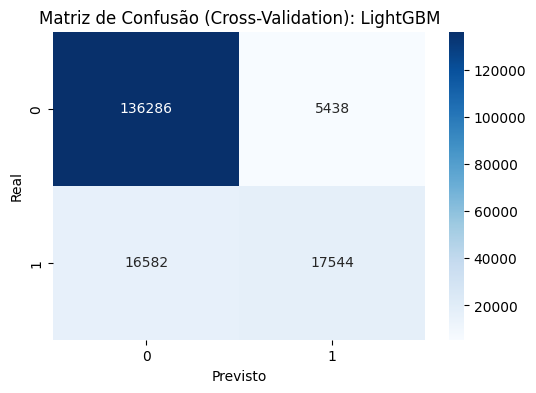


Treinando modelo: RandomForest ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8669 (+/- 0.0007)
Precision: 0.7620
Recall   : 0.4567
F1 Score : 0.5711


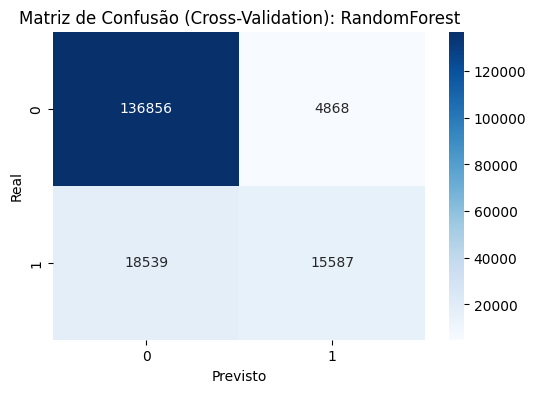


Treinando modelo: XGBoost ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8750 (+/- 0.0011)
Precision: 0.7559
Recall   : 0.5255
F1 Score : 0.6199


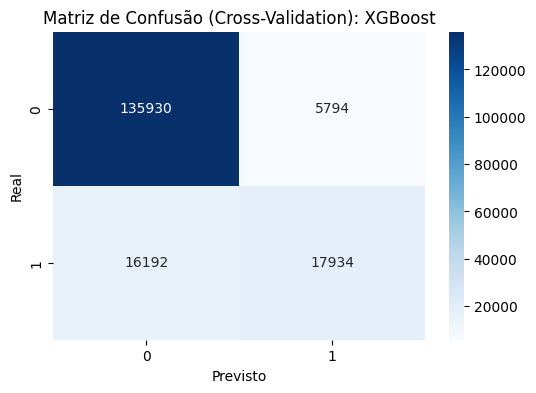


Treinando modelo: SGDClassifier ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8661 (+/- 0.0011)
Precision: 0.7667
Recall   : 0.4509
F1 Score : 0.5652


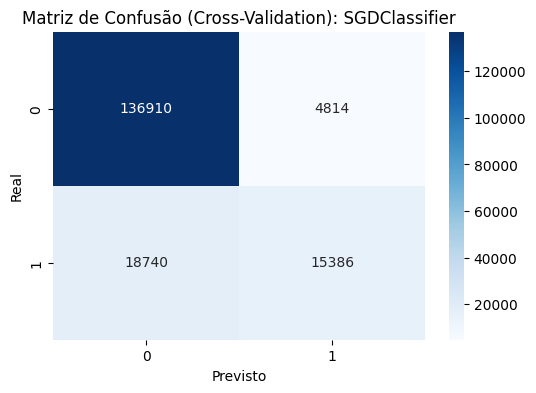


Treinando modelo: LogisticRegression ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8691 (+/- 0.0006)
Precision: 0.7504
Recall   : 0.4879
F1 Score : 0.5913


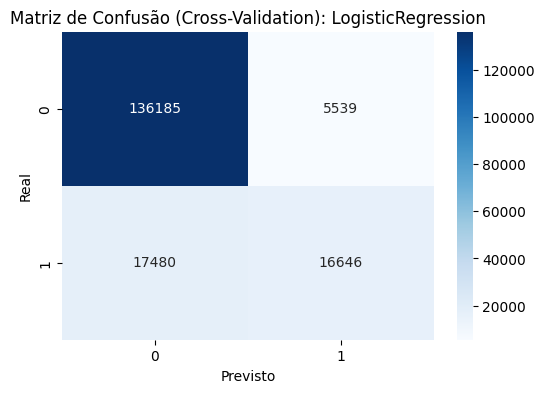


Treinando modelo: DecisionTree ...
--- Model Metrics (Média de 5 folds) ---
Accuracy : 0.8020 (+/- 0.0019)
Precision: 0.4903
Recall   : 0.5165
F1 Score : 0.5031


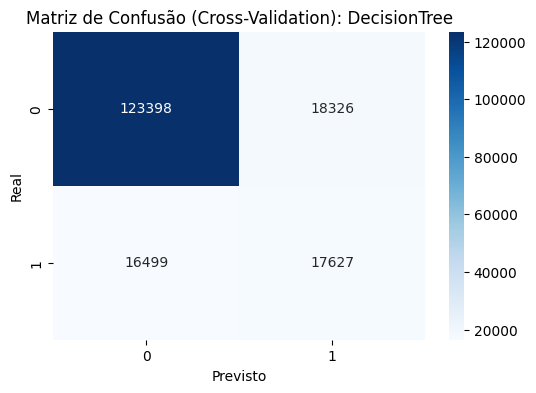

In [62]:
resultado_kfold = model_training_kfold(models_dict,df_cleaned,5)

## Hyperparameters session

In [63]:
#  Dicionário de Parâmetros
param_grids = {
    'LightGBM': {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.2),
        'num_leaves': randint(20, 100),
        'max_depth': randint(3, 10),
        'class_weight': ['balanced']
    },
    'RandomForest': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11),
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'XGBoost': {
        'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4)
    },
    'SGDClassifier': {
        'alpha': uniform(1e-4, 1e-1),
        'penalty': ['l2', 'l1', 'elasticnet'],
        'loss': ['hinge', 'log_loss', 'modified_huber'],
        'class_weight': ['balanced']
    },
    'LogisticRegression': {
        'C': uniform(0.1, 10),
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['balanced']
    },
    'DecisionTree': {
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'criterion': ["gini", "entropy"],
        'class_weight': ['balanced']
    }
}

In [64]:
def model_training_tuned(models_dict:dict, data:pd.DataFrame,test_size:int):
    
    df = data.copy()
    
    # Separação X e y
    X = df.drop('ARRIVAL_DELAY', axis=1)
    y = df['ARRIVAL_DELAY']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    results = {}

    print('=' * 60)
    print(f'Training with Hyperparameter Tuning (RandomizedSearchCV)')
    print(f'X train shape : {X_train.shape} | Y train shape : {y_train.shape}')
    print(f'X test shape : {X_test.shape} | Y test shape: {y_test.shape}')
    print('=' * 60)

    for name, model in models_dict.items():
        print(f'\n Otimizando e treinando: {name}')
        
    
        
        # Verifica se existem parâmetros definidos para este modelo
        if name in param_grids:
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grids[name],
                n_iter=20,  # Tenta 20 combinações diferentes
                scoring='f1', # Métrica de desempenho do algoritmo
                cv=3,       # Cross-validation de 3 folders
                verbose=0,
                random_state=42,
                n_jobs=-1   # Usa todos os processadores
            )
            
            # Treina a busca
            search.fit(X_train, y_train)
            
            # Pega o melhor modelo encontrado
            best_model = search.best_estimator_
            best_params = search.best_params_
            print(f'Melhores parâmetros: {best_params}')
        else:
            # Fallback se não houver grade de parâmetros
            best_model = model
            best_model.fit(X_train, y_train)
            best_params = "Default"

        # Previsão com o MELHOR modelo
        y_pred = best_model.predict(X_test)

        # Métricas
        acc_score = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

        print('--- Metrics (Test Set) ---')
        print(f'Accuracy : {acc_score:.4f}')
        print(f'Precision : {precision:.4f}')
        print(f'Recall : {recall:.4f}')
        print(f'F1 score : {f1:.4f}')

        # Salva resultados
        results[name] = {
            'best_model': best_model,
            'best_params': best_params,
            'accuracy': acc_score,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        # Plot da Matriz de Confusão
        plt.figure(figsize=(4, 3))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.show()

    return results, X_train, X_test, y_test, y_pred

Training with Hyperparameter Tuning (RandomizedSearchCV)
X train shape : (123095, 50) | Y train shape : (123095,)
X test shape : (52755, 50) | Y test shape: (52755,)

 Otimizando e treinando: LightGBM
Melhores parâmetros: {'class_weight': 'balanced', 'learning_rate': np.float64(0.07506606615265286), 'max_depth': 7, 'n_estimators': 437, 'num_leaves': 72}
--- Metrics (Test Set) ---
Accuracy : 0.8301
Precision : 0.5448
Recall : 0.7570
F1 score : 0.6336


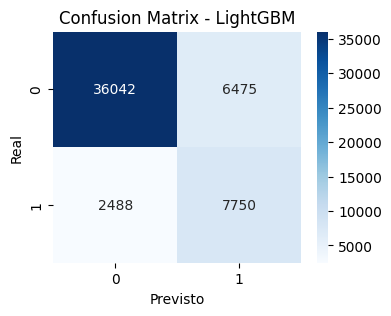


 Otimizando e treinando: RandomForest
Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 445}
--- Metrics (Test Set) ---
Accuracy : 0.8429
Precision : 0.5841
Recall : 0.6619
F1 score : 0.6206


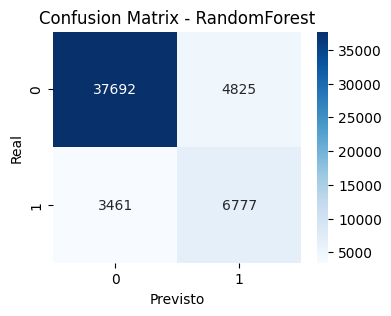


 Otimizando e treinando: XGBoost
Melhores parâmetros: {'learning_rate': np.float64(0.0849080237694725), 'max_depth': 7, 'n_estimators': 370, 'subsample': np.float64(0.892797576724562)}
--- Metrics (Test Set) ---
Accuracy : 0.8760
Precision : 0.7572
Recall : 0.5311
F1 score : 0.6243


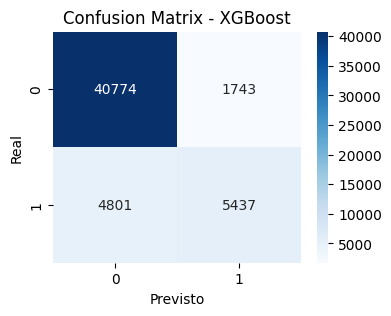


 Otimizando e treinando: SGDClassifier
Melhores parâmetros: {'alpha': np.float64(0.004745041271999773), 'class_weight': 'balanced', 'loss': 'modified_huber', 'penalty': 'elasticnet'}
--- Metrics (Test Set) ---
Accuracy : 0.8029
Precision : 0.4950
Recall : 0.7643
F1 score : 0.6009


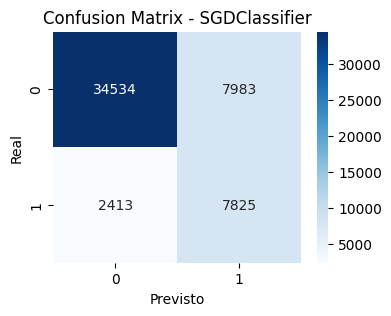


 Otimizando e treinando: LogisticRegression
Melhores parâmetros: {'C': np.float64(1.9340450985343383), 'class_weight': 'balanced', 'solver': 'lbfgs'}
--- Metrics (Test Set) ---
Accuracy : 0.8011
Precision : 0.4920
Recall : 0.7745
F1 score : 0.6018


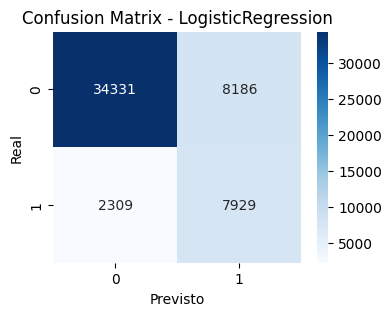


 Otimizando e treinando: DecisionTree
Melhores parâmetros: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 11}
--- Metrics (Test Set) ---
Accuracy : 0.7846
Precision : 0.4654
Recall : 0.7408
F1 score : 0.5717


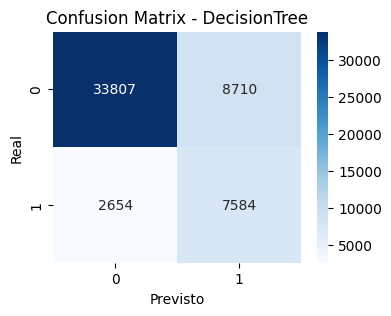

In [65]:
resultados_Hyperparameter, X_train_final, X_test_final, y_test_final, y_pred_final = model_training_tuned(models_dict, df_cleaned,0.3)

In [66]:
def plot_model_comparison(results: dict):
    """
    Transforma o dicionário de resultados em um DataFrame
    e plota um gráfico comparativo das métricas.
    """
    
    data_list = []
    for model_name, metrics in results.items():
        data_list.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1_score']
        })
    
    df_results = pd.DataFrame(data_list)
    
    df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    chart = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='viridis')
    
    plt.title('Comparação de Performance dos Modelos', fontsize=16)
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=45)
    
    for container in chart.containers:
        chart.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()
    
    best_model_name = df_results.loc[df_results['F1 Score'].idxmax()]['Model']
    best_f1 = df_results['F1 Score'].max()
    
    print(f"\n O Modelo Campeão (baseado no F1 Score) foi: {best_model_name}")
    print(f"   Com F1 Score de: {best_f1:.4f}")
    
    return df_results

### Gráficos de Resultados dos Modelos

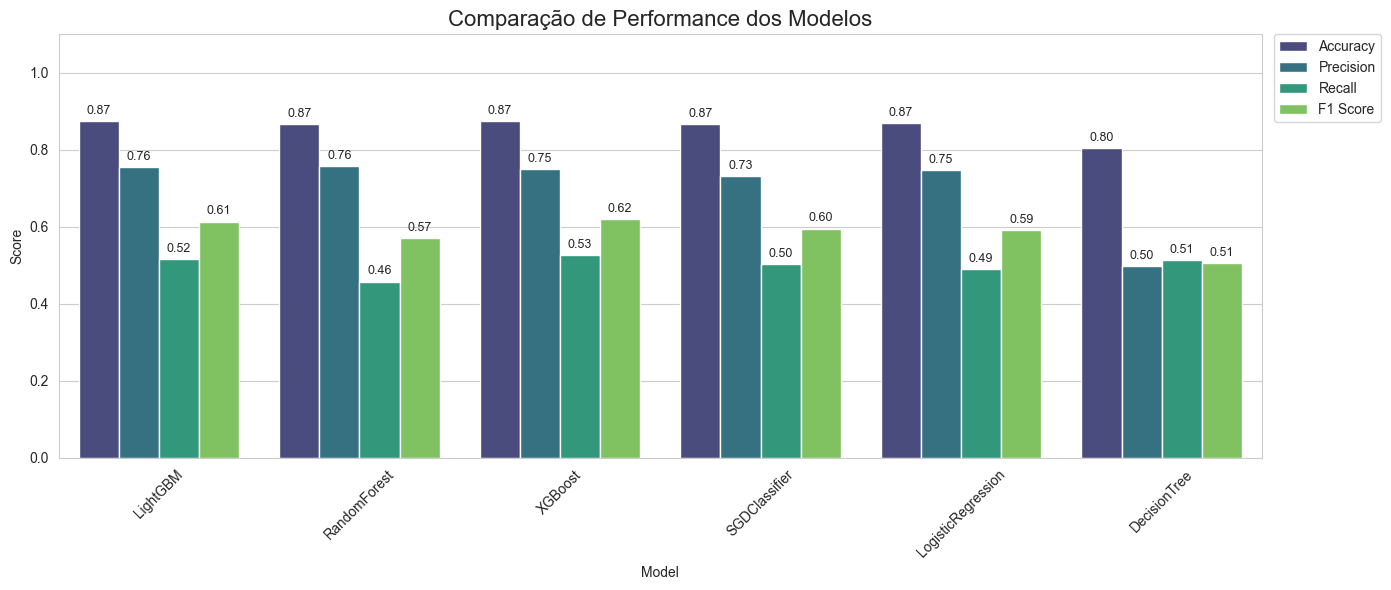


 O Modelo Campeão (baseado no F1 Score) foi: XGBoost
   Com F1 Score de: 0.6191


,Model,Accuracy,Precision,Recall,F1 Score
0,LightGBM,0.87,0.76,0.52,0.61
1,RandomForest,0.87,0.76,0.46,0.57
2,XGBoost,0.87,0.75,0.53,0.62
3,SGDClassifier,0.87,0.73,0.50,0.60
4,LogisticRegression,0.87,0.75,0.49,0.59
5,DecisionTree,0.80,0.50,0.51,0.51


In [67]:
# Performance Modelos
plot_model_comparison(resultados)

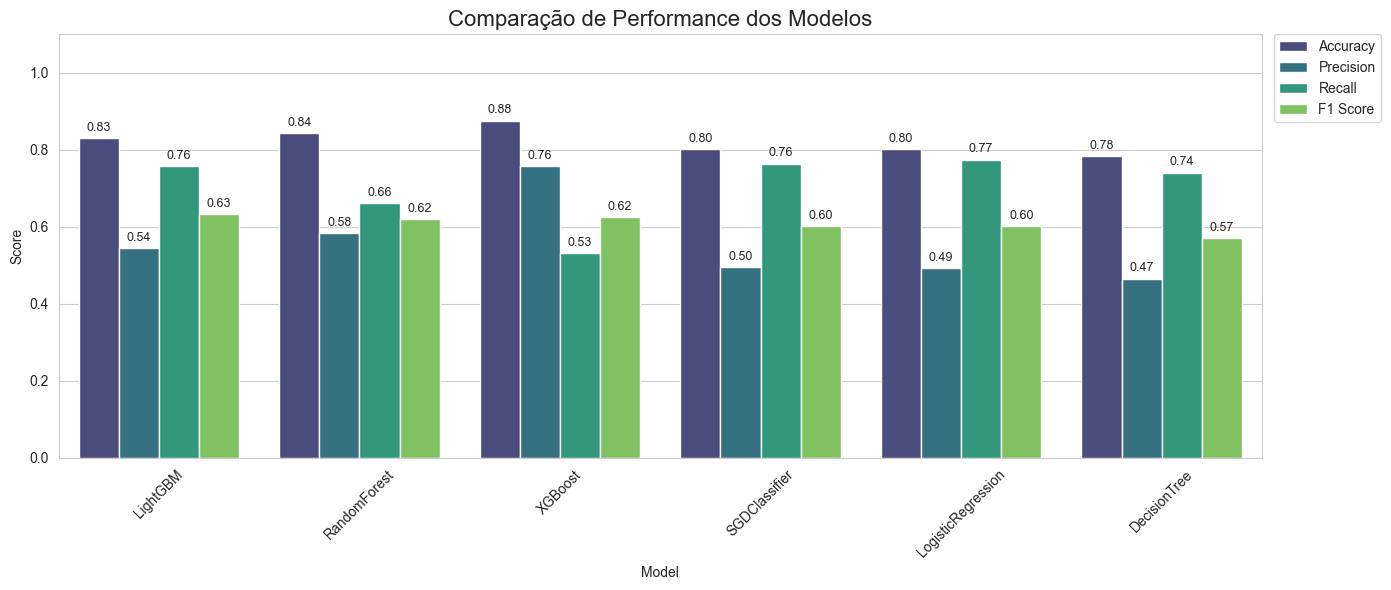


 O Modelo Campeão (baseado no F1 Score) foi: LightGBM
   Com F1 Score de: 0.6336


,Model,Accuracy,Precision,Recall,F1 Score
0,LightGBM,0.83,0.54,0.76,0.63
1,RandomForest,0.84,0.58,0.66,0.62
2,XGBoost,0.88,0.76,0.53,0.62
3,SGDClassifier,0.80,0.50,0.76,0.60
4,LogisticRegression,0.80,0.49,0.77,0.60
5,DecisionTree,0.78,0.47,0.74,0.57


In [68]:
# Performance Modelos com Hyperparameters
plot_model_comparison(resultados_Hyperparameter)

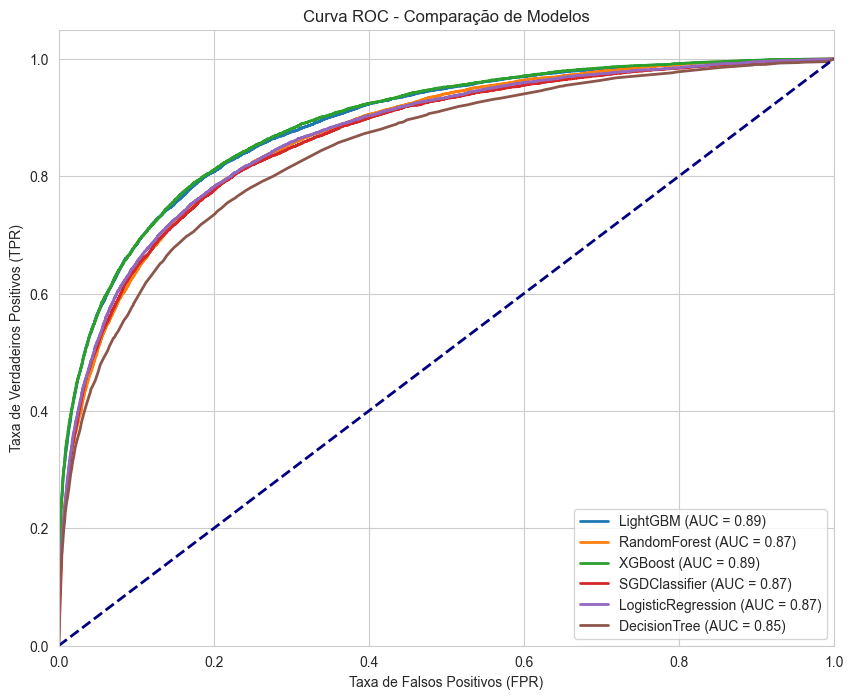

In [69]:
plt.figure(figsize=(10, 8))

# Loop para gerar as curvas ROC
for name, info in resultados_Hyperparameter.items():
    model = info['best_model']
    
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_final)[:, 1]
        else:
            # Para modelos como SVM ou SGD sem log_loss, usa-se decision_function
            y_prob = model.decision_function(X_test_final)
            
        fpr, tpr, _ = roc_curve(y_test_final, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
        
    except Exception as e:
        print(f"Não foi possível gerar ROC para {name}: {e}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend(loc="lower right")
plt.show()

In [70]:
def plot_feature_importance(models_dict, features_df, top_n=20):
    
    importances = models_dict.feature_importances_
    feature_names = features_df.columns
    
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(top_n), palette='viridis')
    plt.title(f'Top {top_n} Feature Importance')
    plt.xlabel('Importância (Score)')
    plt.ylabel('Variáveis')
    plt.show()
    
    return feature_imp_df

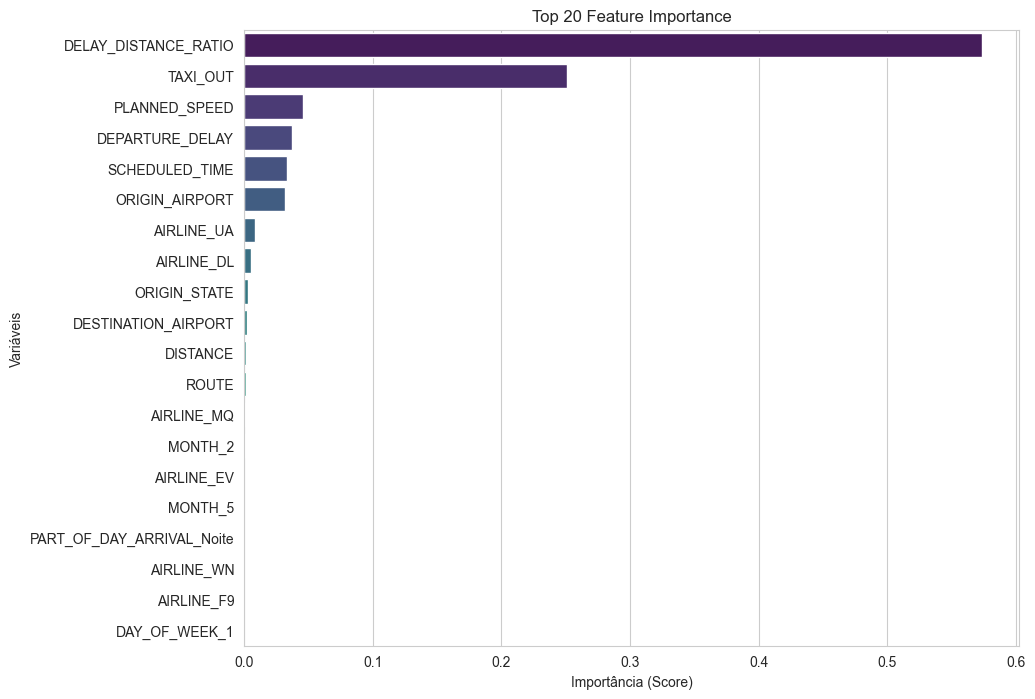

In [71]:
df_importancia = plot_feature_importance(model, X_train)

Calculando importância para: LightGBM
Calculando importância para: RandomForest
Calculando importância para: XGBoost
Calculando importância para: SGDClassifier
Calculando importância para: LogisticRegression
Calculando importância para: DecisionTree


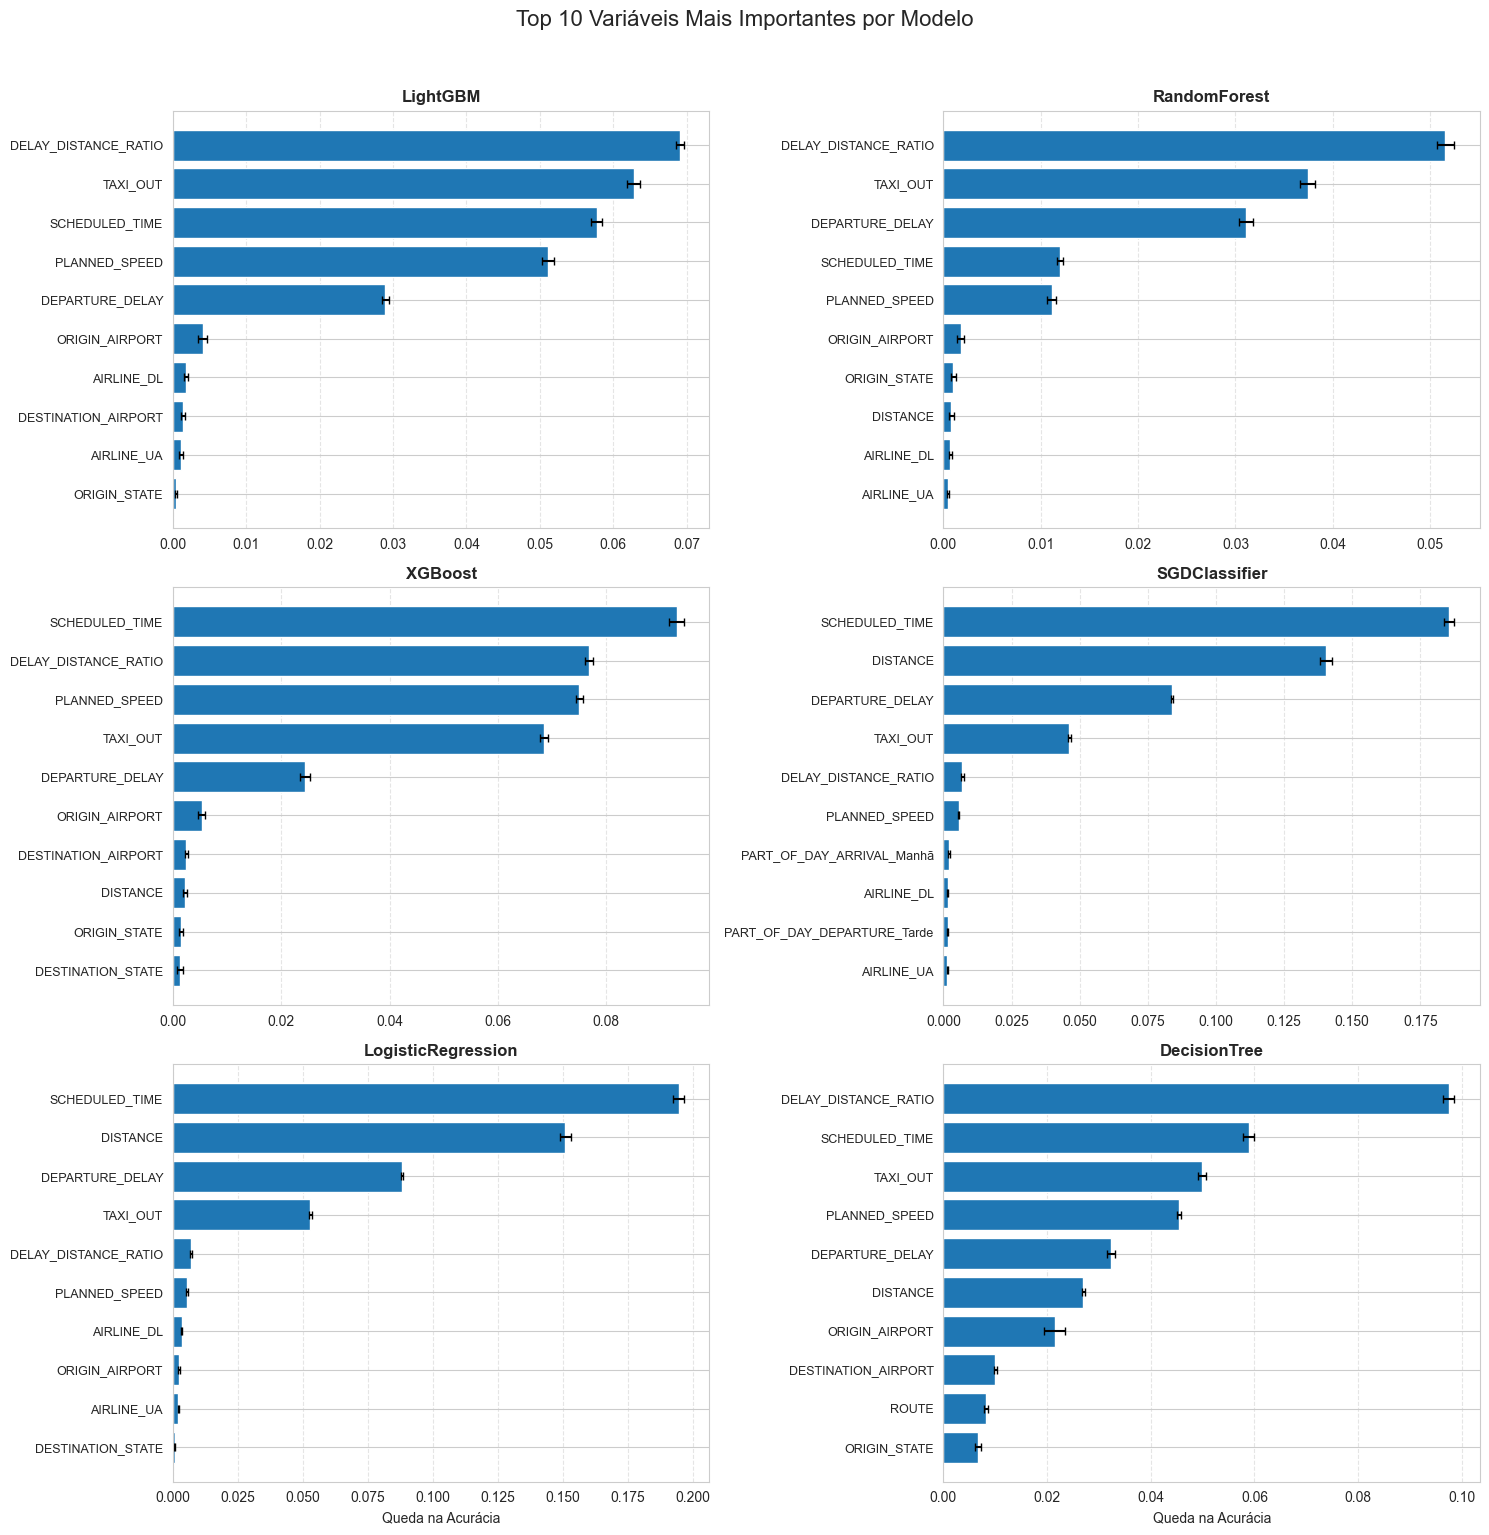

In [72]:
# Mede o quanto o modelo sofre se perder a informação no teste

n_rows = int(np.ceil(len(models_dict) / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples para iterar

# Loop para percorrer cada modelo
for i, (name, model) in enumerate(models_dict.items()):
    ax = axes[i] # Seleciona o gráfico atual
    
    print(f"Calculando importância para: {name}")
    
    # --- Cálculo da Permutation Importance ---
    # Nota: O modelo DEVE estar treinado (.fit)
    try:
        result = permutation_importance(
            estimator=model,
            X=X_test,
            y=y_test,
            scoring='accuracy',
            n_repeats=5, # Reduzi para 5 para ser mais rápido (pode usar 10)
            random_state=42,
            n_jobs=-1
        )
    except Exception as e:
        print(f"Erro ao calcular para {name}: {e}")
        ax.text(0.5, 0.5, 'Erro no Modelo', ha='center')
        continue

    # Ordena e pega os Top N
    sorted_idx = result.importances_mean.argsort()[-10:]
    
    # --- Plotagem ---
    ax.barh(
        range(len(sorted_idx)),
        result.importances_mean[sorted_idx],
        xerr=result.importances_std[sorted_idx],
        align='center',
        color='#1f77b4',
        capsize=3
    )
    
    # Ajustes visuais de cada sub-gráfico
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels(X_test.columns[sorted_idx], fontsize=9)
    ax.set_title(f"{name}", fontsize=12, fontweight='bold')
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Apenas coloca label no eixo X na última linha para limpar o visual
    if i >= len(models_dict) - 2:
        ax.set_xlabel("Queda na Acurácia")

# Remove gráficos vazios (se o número de modelos for ímpar)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Top {10} Variáveis Mais Importantes por Modelo", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [73]:
sorted_idx = result.importances_mean.argsort()
print("Importâncias das variáveis:")
for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]:<30} "
          f"{result.importances_mean[i]:.4f} "
          f" +/- {result.importances_std[i]:.4f}")

Importâncias das variáveis:
DELAY_DISTANCE_RATIO           0.0975  +/- 0.0011
SCHEDULED_TIME                 0.0589  +/- 0.0010
TAXI_OUT                       0.0498  +/- 0.0008
PLANNED_SPEED                  0.0454  +/- 0.0004
DEPARTURE_DELAY                0.0324  +/- 0.0008
DISTANCE                       0.0270  +/- 0.0002
ORIGIN_AIRPORT                 0.0215  +/- 0.0020
DESTINATION_AIRPORT            0.0100  +/- 0.0003
ROUTE                          0.0081  +/- 0.0004
ORIGIN_STATE                   0.0067  +/- 0.0005
DESTINATION_STATE              0.0033  +/- 0.0006
AIRLINE_EV                     0.0018  +/- 0.0003
AIRLINE_WN                     0.0015  +/- 0.0002
AIRLINE_UA                     0.0013  +/- 0.0003
AIRLINE_DL                     0.0011  +/- 0.0003
AIRLINE_B6                     0.0011  +/- 0.0002
AIRLINE_AA                     0.0010  +/- 0.0002
AIRLINE_OO                     0.0007  +/- 0.0001
AIRLINE_AS                     0.0006  +/- 0.0002
DAY_OF_WEEK_5         